In [1]:
!pip install sysidentpy
!pip install ace
!pip install tqdm
## imports all dependencies
import pandas as pd
import os
from pandas import Timestamp
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from pandas._libs.tslibs.timestamps import Timestamp
from datetime import datetime, timedelta
from tensorflow.keras import layers, regularizers
%matplotlib inline
from IPython.display import display, clear_output
import time
import sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from tqdm import tqdm
from scipy.stats import pearsonr
from ace import model
from ace import ace
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 4.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
class main:
  def __init__(self, file_path, resolution='D'):
    self.file_path = file_path
    self.en_ch = 2
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.dropna(inplace=True)
    # omni_data=pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/SOLAR_WIND/Wave_hiss/wave_data_1_3_khz')
    omni_data=pd.read_csv('/content/drive/MyDrive/UNI-STUFF/4th year/diss/Data_for_FYP/SOLAR_WIND/OMNI_raw/OMNI_FULL_1986_2019.csv')
    omni_data['Date'] = pd.to_datetime(omni_data['Date'])
    omni_data.set_index('Date', inplace=True)
    omni_data.dropna(inplace=True)
    def make_timezone_aware(df, timezone='UTC'):
      if df.index.tz is None:
            # If timezone-naive, localize to the specified timezone
            df.index = df.index.tz_localize(timezone)
        # Return the possibly modified DataFrame
      return df
    df = make_timezone_aware(df)
    self.omni_data = make_timezone_aware(omni_data)
    omni_resampled = self.omni_data.resample(resolution).mean()
    df_resampled = df.resample(resolution).mean()
    self.df = pd.merge(df_resampled, omni_resampled, left_index=True, right_index=True, how='left')
    self.df.dropna(inplace=True)

  def custom_date_rng(self, start_date=[1950, 1, 1], end_date=[2050, 1, 1]):
    self.start_date, self.end_date = Timestamp(datetime(start_date[0], start_date[1], start_date[2]), tz='UTC'), Timestamp(datetime(end_date[0], end_date[1], end_date[2]), tz='UTC')
    self.df = self.df[(self.df.index >= self.start_date) & (self.df.index <= self.end_date)]

  def custom_prmtr_rng(self):
    incl_cols=[]
    flux_col_identified = False
    for col in self.df.columns:
      if not flux_col_identified:
            q_str = f"{col} include this parameter (y/n) if the flux value respond (f)? "
      else:
            q_str = f"Include {col} as a parameter (y/n)? "
      user_input = input(q_str).strip().lower()
      if user_input == 'y':
        incl_cols.append(col)
      if user_input == 'f':
        incl_cols.append(col)
        flux_col = col
        en_ch = input(f"Energy Channel of {col} (float) MeV?")
        self.en_ch = float(en_ch)
        flux_col_identified = True
    incl_cols.remove(flux_col)
    incl_cols.insert(0, flux_col)
    self.df = self.df[incl_cols]
    self.df.rename(columns={flux_col: 'log_Average_Flux'}, inplace=True)

  def graph_multiple_prmtrs(self, size=(24, 3), input_cols=[0,1,2,3,4], start_year = 1800, end_year = 2050):
    start_date = Timestamp(datetime(start_year, 1, 1), tz='UTC')
    end_date = Timestamp(datetime(end_year, 12, 31), tz='UTC')
    if start_date <= self.df.index[0]:
      start_date_str = self.df.index[0].strftime('%Y-%m-%d')
    else:
      start_date_str = start_date.strftime('%Y-%m-%d')
    if end_date >= self.df.index[-1]:
      end_date_str = self.df.index[-1].strftime('%Y-%m-%d')
    else:
      end_date_str = end_date.strftime('%Y-%m-%d')
    num_cols = len(input_cols)
    fig, axes = plt.subplots(num_cols, 1, figsize=(size[0], size[1]*num_cols))
    if num_cols == 1:  # If there's only one plot, axes is not an array
      axes = [axes]
    self.df_reduced = self.df[(self.df.index >= start_date) & (self.df.index <= end_date)]
    for i, col_index in enumerate(input_cols):
        if col_index < len(self.df_reduced.columns):
          self.df_reduced[self.df_reduced.columns[col_index]].plot(ax=axes[i], kind='line', title=self.df_reduced.columns[col_index], color='black')
          axes[i].grid(True)
        else:
          print(f"Column index {col_index} is out of bounds.")
    plt.tight_layout()
    plt.show()

  def NARMAX(self, days_ahead=1, back_log=0, polynomial_deg=2):
    self.m_type = 'NARMAX'
    self.days_ahead = days_ahead
    self.back_log = back_log
    self.pol_deg = polynomial_deg
    split_values = []
    self.df_id, self.df_val = self.df[1::2], self.df[::2]
    for column in self.df.columns:
      # Extract values for the current column and split them
      column_values = self.df[column]
      column_split = column_values[1::2].values.reshape(-1, 1), column_values[::2].values.reshape(-1, 1)
      # Append the split values to the list
      split_values.append(column_split)
    x_id = np.concatenate([split[0] for split in split_values[1:]], axis=1)
    x_val = np.concatenate([split[1] for split in split_values[1:]], axis=1)
    y_id, y_val = split_values[0]
    self.x_id, self.x_val, self.y_id, self.y_val = x_id, x_val, y_id, y_val
    ## read through examples in https://sysidentpy.org/examples/f_16_benchmark/
    def NARMAX_model(df, x_id, x_val, y_id, y_val, back_log, days_ahead, pol_degree):
      # Create a dictionary to store lag values for each feature
      lag_values = []
      # Loop through each column in the DataFrame except for the target feature
      for column in df.columns:
        if column != df.columns[0]:  # Exclude the target column
          lag_values.append(list(range(1, back_log)))
      basis_function = Polynomial(degree=pol_degree)
      model = FROLS(
          order_selection=True,
          n_info_values=39,
          extended_least_squares=False,
          ylag=2,
          xlag=lag_values,
          info_criteria="bic",
          estimator='least_squares',
          basis_function=basis_function,
      )
      model.fit(X=x_id, y=y_id)
      y_hat = model.predict(X=x_val, y=y_val, steps_ahead = days_ahead)
      rrse = root_relative_squared_error(y_val, y_hat)
      r = pd.DataFrame(
        results(
              model.final_model,
              model.theta,
              model.err,
              model.n_terms,
              err_precision=8,
              dtype="sci",
          ),
          columns=["Regressors", "Parameters", "ERR"],
      )
      return r, y_hat
    self.r, self.y_pred = NARMAX_model(self.df, self.x_id, self.x_val, self.y_id, self.y_val, self.back_log, self.days_ahead, self.pol_deg)
    self.scaled = False

  def FFNN_compile(self, days_ahead=1, back_log=0, AR=False, learn_rate=0.0007, Architecture = [{"units": 64, "activation": "relu", "regularizer": regularizers.l1(0.0001)}, {"units": 64, "activation": "relu", "regularizer": regularizers.l1(0.0001)}, {"units": 10, "activation": "relu"}]):
    # delay and step ahead
    self.m_type = 'FFNN'
    self.days_ahead = days_ahead
    self.back_log = back_log
    self.original_columns = self.df.columns[1:]
    self.learn_rate = learn_rate
    if AR == True:
      for col in self.df.columns:
          for i in range(self.days_ahead, self.back_log + self.days_ahead):
            self.df[f"{col}_{i}_days_ago"] = self.df[col].shift(i)
    else:
      for col in self.original_columns:
          for i in range(self.days_ahead, self.back_log + self.days_ahead):
            self.df[f"{col}_{i}_days_ago"] = self.df[col].shift(i)
    self.df.drop(columns=self.original_columns, inplace=True)
    # scaling
    self.scaler = MinMaxScaler()
    self.df.dropna(inplace=True)
    self.X = self.df.drop('log_Average_Flux', axis=1)
    self.y = self.df[['log_Average_Flux']]
    for col in self.X.columns:
      column_data_X = self.X[col].values.reshape(-1, 1)
      self.X[col] = self.scaler.fit_transform(column_data_X)
    for col in self.y.columns:
      column_data_y = self.y[col].values.reshape(-1, 1)
      self.y[col] = self.scaler.fit_transform(column_data_y)
    self.scaled = True
    #sets random seed
    random_seed = 30
    tf.random.set_seed(random_seed)
    # Split into training and testing sets
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
    # model creation
    self.model = tf.keras.Sequential()
    self.model.add(tf.keras.Input(shape=(self.X_train.shape[1])))
    self.num_layers_A = len(Architecture)
    for layer_spec in Architecture:
      # Extract layer parameters with .get to provide defaults if key not present
      units = layer_spec.get("units")
      self.dim = units
      activation = layer_spec.get("activation")
      self.act = activation
      regularizer = layer_spec.get("regularizer", None)  # Default to None if not specified
      # Add the Dense layer to the model with the specified parameters
      self.model.add(tf.keras.layers.Dense(units, activation=activation, kernel_regularizer=regularizer))
    self.model.add(tf.keras.layers.Dense(1, activation=None))
    self.model.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=["mae"])

  def RNN_compile(self, days_ahead=1, back_log=1, AR=False, learn_rate=0.0007, Architecture = [{"units": 64, "activation": "relu", "regularizer": regularizers.l1(0.0001), "l_type": "LSTM", "return": True}, {"units": 64, "activation": "relu", "regularizer": regularizers.l1(0.0001), "l_type": "LSTM", "return": False}, {"units": 10, "activation": "tanh", "return": False}]):
    # delay and step ahead
    self.m_type = 'RNN'
    self.days_ahead = days_ahead
    self.back_log = back_log
    self.original_columns = self.df.columns[1:]
    self.learn_rate = learn_rate
    # step ahead for recurrant neural network
    if AR == True:
      for col in self.df.columns:
        self.df[f"{col}_{self.days_ahead}_days_ago"] = self.df[col].shift(self.days_ahead)
    else:
      for col in self.original_columns:
        self.df[f"{col}_{self.days_ahead}_days_ago"] = self.df[col].shift(self.days_ahead)
    # Remove the original columns, excluding the first one (assuming it's 'log_Average_Flux' or similar)
    self.df.drop(columns=self.original_columns, inplace=True)
    self.df.dropna(inplace=True)
    # scales
    self.scaler = MinMaxScaler()
    self.X = self.df.drop('log_Average_Flux', axis=1)
    self.y = self.df[['log_Average_Flux']]
    # initialises scaled X data before transform (easier than doing after)
    for col in self.X.columns:
      column_data_X = self.X[col].values.reshape(-1, 1)
      self.X[col] = self.scaler.fit_transform(column_data_X)
    for col in self.y.columns:
      column_data_y = self.y[col].values.reshape(-1, 1)
      self.y[col] = self.scaler.fit_transform(column_data_y)
    self.scaled = True
    # Initialize an empty list to store the values
    larger_values = []
    # Iterate over the columns of the DataFrame
    for col in self.X.columns:
      columns = self.X[col]
      values = []
      for i in range(self.back_log, len(columns)):
        current_and_previous_values = columns[i-self.back_log:i+1].values
        values.append(current_and_previous_values)
      #self.X[col] = values
      larger_values.append(values)
    final = np.transpose(np.array(larger_values), (1, 2, 0))
    self.X = final
    # creates an array of the dates, still have to apply this back in???
    index_array=self.df.index.to_numpy()
    self.dates_array = index_array[self.back_log:]
    # creates scaled targets array
    self.y = self.y.iloc[self.back_log:]
    random_seed = 30
    tf.random.set_seed(random_seed)
    # Split into training and testing sets
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
    # Initialize RNN model
    self.model = tf.keras.Sequential()
    self.model.add(tf.keras.Input(shape=(self.X_train.shape[1], self.X_train.shape[2])))
    self.num_layers_A = len(Architecture)
    for layer_spec in Architecture:
      units = layer_spec.get("units")
      self.dim = units
      activation = layer_spec.get("activation")
      self.act = activation
      regularizer = layer_spec.get("regularizer", None)  # Default to None if not specified
      l_type = layer_spec.get("l_type", None)
      return_seq = layer_spec.get("return", False)
      if l_type == "LSTM":
        self.model.add(tf.keras.layers.LSTM(units, return_sequences=return_seq, kernel_regularizer=regularizer))
        self.LSTM_is_there = True
      else:
        self.model.add(tf.keras.layers.Dense(units, activation=activation, kernel_regularizer=regularizer))
    self.model.add(tf.keras.layers.Dense(1, activation=None))
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    self.model.compile(loss=tf.keras.losses.mae, optimizer=self.optimizer, metrics=["mae"])

  def NN_train(self, epoch_num=300, batch_num=150, visible=1, is_saved=False,arg_str=None):
    self.history = self.model.fit(self.X_train, self.y_train, epochs=epoch_num, batch_size=batch_num, validation_data=(self.X_test, self.y_test), shuffle=True, verbose=visible)
    self.loss = self.model.evaluate(self.X_test, self.y_test)
    loss_DF = pd.DataFrame()
    if is_saved:
      save_str = f"val_{arg_str}" # self.learn_rate}"
      save_fp = str('/content/drive/MyDrive/4th year/diss/grid_search/' + save_str)
      loss_DF[save_str] = self.history.history['val_loss']
      loss_DF.to_csv(save_fp, index=True)
    if visible == 1:
      plt.plot(self.history.history['loss'], label='Training Loss')
      plt.plot(self.history.history['val_loss'], label='Validation Loss', linestyle='--')
      plt.title('Loss Over Time')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()

  def NN_predict(self):
    self.y_pred = self.model.predict(self.X_test)

  def graph_with_error(self, start_year=1800, end_year=2200):
    if self.scaled == True:
      self.y_test_unscaled = self.scaler.inverse_transform(self.y_test.iloc[:, 0].values.reshape(-1, 1))
      self.df_graph  = self.y_test.drop(self.y_test.columns.difference(['Date']), axis=1)
      self.df_graph['log_Average_Flux'] = self.y_test_unscaled
      self.y_pred_unscaled = self.scaler.inverse_transform(self.y_pred.reshape(-1, 1))
      self.df_graph['y_prediction'] = self.y_pred_unscaled
    if self.scaled == False:
      self.df_graph  = self.df_val.drop(self.df_val.columns.difference(['Date']), axis=1)
      self.df_graph['log_Average_Flux'] = self.y_val
      self.df_graph['y_prediction'] = self.y_pred
    self.df_graph.sort_values(by='Date', inplace = True)
    self.df_graph['SquaredError'] = (self.df_graph['log_Average_Flux'] - self.df_graph['y_prediction']) ** 2
    # self.df_graph_resampled = self.df_graph.resample('3M').transform('mean')
    window_size = 365
    window_size2 = 80
    self.df_graph_resampled = self.df_graph.rolling(window=window_size, min_periods=1).mean()
    self.df_graph_resampled2 = self.df_graph.rolling(window=window_size2, min_periods=1).mean()
    sunspots_df = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/HelioSphere/ISSN_D_tot.csv')
    sunspots_df['Date'] = pd.to_datetime(sunspots_df['Date'])
    sunspots_df.set_index('Date', inplace=True)
    # sunspots_df_resampled = sunspots_df.resample('3M').transform('mean')
    sunspots_df_resampled = sunspots_df.rolling(window=window_size, min_periods=1).mean()
    start_date = Timestamp(datetime(start_year, 1, 1), tz='UTC')
    end_date = Timestamp(datetime(end_year, 12, 31), tz='UTC')
    if start_date <= self.df_graph.index[0]:
      start_date_str = self.df_graph.index[0].strftime('%Y-%m-%d')
    else:
      start_date_str = start_date.strftime('%Y-%m-%d')
    if end_date >= self.df_graph.index[-1]:
      end_date_str = self.df_graph.index[-1].strftime('%Y-%m-%d')
    else:
      end_date_str = end_date.strftime('%Y-%m-%d')
    df_subset = self.df_graph[(self.df_graph.index >= start_date) & (self.df_graph.index <= end_date)]
    min_date = df_subset.index.min()
    max_date = df_subset.index.max()
    df_resampled = self.df_graph_resampled[(self.df_graph_resampled.index >= min_date) & (self.df_graph_resampled.index <= max_date)]
    df_resampled2 = self.df_graph_resampled2[(self.df_graph_resampled2.index >= min_date) & (self.df_graph_resampled2.index <= max_date)]
    sunspots_df_subset = sunspots_df[(sunspots_df.index >= min_date) & (sunspots_df.index <= max_date)]
    sun_df_resampled = sunspots_df_resampled[(sunspots_df_resampled.index >= min_date) & (sunspots_df_resampled.index <= max_date)]
    plt.figure(figsize=(20, 12))
    plt.subplot(3, 1, 1)
    plt.plot(df_subset.index, df_subset['log_Average_Flux'], label='Real Flux', color='black')
    plt.plot(df_subset.index, df_subset['y_prediction'], label='Flux prediction', color='red', alpha=0.8)
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Log Average Flux')
    start_str = 'Log Average Flux and Flux Prediction ' + str(self.days_ahead) + ' days ahead, between: '
    end_str = ' using ' + str(self.back_log) + ' days previous data.'
    plt.title(start_str + start_date_str + ' and ' + end_date_str + end_str)  # Adjust title as needed
    plt.legend()
    plt.subplot(3, 1, 2)
    ax1 = plt.gca()
    ax1.plot(df_subset.index, df_subset['SquaredError'], label='Squared Error', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Squared Error')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(sunspots_df_subset.index, sunspots_df_subset['MonthlyAvgSunspotNumber'], label='Sunspot Number', color='black', alpha=0.6)
    ax2.set_ylabel('Sunspot Number', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper right')
    plt.title('Squared Error over Time in Prediction: ' + start_date_str +' to '  + end_date_str + ' Compared with SSN')
    plt.subplot(3, 1, 3)
    ax1 = plt.gca()
    ax1.plot(df_resampled2.index, df_resampled2['SquaredError'], label='Rolling Averaged Squared Error', color='orange')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Squared Error', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(sun_df_resampled.index, sun_df_resampled['MonthlyAvgSunspotNumber'], label='Sunspot Number', color='black', alpha=0.6)
    ax2.set_ylabel('year average Sunspot Number', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(df_resampled.index, df_resampled['log_Average_Flux'], label='Rolling Averaged Flux', color='blue', alpha=0.4)
    ax3.set_ylabel('Yearly Averaged Flux', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax3.legend(loc='lower right')
    plt.title('Mean Squared Error over Time in Prediction: ' + start_date_str +' to '  + end_date_str)
    plt.tight_layout()
    plt.show()

  def validate(self):
    mse = mean_squared_error(self.df_graph['log_Average_Flux'], self.df_graph['y_prediction'])
    variance = self.df_graph['log_Average_Flux'].var()
    PE = 1-(mse/variance)
    print('PE:')
    print(PE)
    print('MSE:')
    print(mse)
    return PE, mse

  def validate_window(self, start_date, end_date):
    start_date = Timestamp(datetime(start_date, 1, 1), tz='UTC')
    end_date = Timestamp(datetime(end_date, 1, 1), tz='UTC')
    df_subset = self.df_graph[(self.df_graph.index >= start_date) & (self.df_graph.index <= end_date)]
    mse=mean_squared_error(df_subset['log_Average_Flux'], df_subset['y_prediction'])
    variance = df_subset['log_Average_Flux'].var()
    PE = 1-(mse/variance)
    print('PE:')
    print(PE)
    print('MSE:')
    print(mse)
    return PE, mse

  def make_architecture(self, num_of_layers=2):
    Architecture = []
    First_loop = True
    for i in range(num_of_layers):
      unit_input = int(input('nodes in layer: '))
      activation_input = input('activation function: ')
      regularizer_check = input('regularizer? y/n ')
      if regularizer_check == 'n':
        regularizer_input = None
      if regularizer_check == 'y':
        l_check= input('l1/l2? ')
        weight = float(input('weight? '))
        if l_check == 'l1':
          regularizer_input = regularizers.l1(weight)
        if l_check == 'l2':
          regularizer_input = regularizers.l2(weight)
      lstm_check = input('LSTM? y/n ')
      if lstm_check == 'y':
        layer_type = 'LSTM'
        returnable = First_loop
        First_loop=False
      else:
        layer_type = 'Dense'
        returnable = False
      Architecture_i = {
          'units': unit_input,
          'activation': activation_input,
          'regularizer': regularizer_input,
          'l_type': layer_type,
          'return': returnable
      }
      Architecture.append(Architecture_i)
    return Architecture

  def plot_results_combo(self, file_paths, delay_study=False, rescaled=False, multi_en_channel=False):
    methods = []
    for i in file_paths:
      method=input('what is the method of this file?' + i + ' ')
      methods.append(method)
    dict_files = dict(zip(methods, file_paths))
    index_col=0
    all_dataframes = []
    for method, fp in dict_files.items():
      df_temp = pd.read_csv(fp, index_col=index_col)
      df_temp.columns = [f"{col}_{method}" for col in df_temp.columns]
      all_dataframes.append(df_temp)
    concat_df = pd.concat(all_dataframes, axis=1)
    def remove_mean(df):
          for col in df.columns:
            data_col = df[col]
            centered_col = data_col - data_col.mean()
            df[col] = centered_col
          return df
    def scale(df):
          scaler = MinMaxScaler()
          for col in df.columns:
            column_data = df[col].values.reshape(-1, 1)
            df[col] = scaler.fit_transform(column_data)
    if rescaled == True:
      concat_df = remove_mean(concat_df)
    if delay_study == False:
      df_flux = concat_df.filter(like='log_Average_Flux')
      df_pred = concat_df.filter(like='y_prediction')
      if multi_en_channel== False:
        log_Average_Flux_values = df_flux.iloc[:, 0].values
        df_pred.insert(0, 'log_Average_Flux', log_Average_Flux_values)
      if multi_en_channel== True:
        for i, meth in enumerate(methods):
          log_Average_Flux_values = df_flux.iloc[:, i].values
          df_pred.insert(0, f'log_Average_Flux_{methods[i]}', log_Average_Flux_values)
      df_error = concat_df.filter(like='SquaredError')
      df_pred_monthly = df_pred.resample('M').mean()
      df_error_monthly = df_error.resample('M').mean()
      str_1 = f"Plot of Flux Prediction for each model"
      str_2 = f"Plot of Error for each model"
      str_y = f"Prediction of Flux against actual Flux data"
    elif delay_study == True:
      df_pred_monthly = concat_df.filter(like='PE')
      df_error_monthly = concat_df.filter(like='MSE')
      str_1 = f"Plot of Prediction Efficiency over delay"
      str_2 = f"Plot of MSE over delay"
      str_y = f"Prediction Efficiency of Flux"
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    df_pred_monthly.plot(colormap='viridis', alpha=0.8, ax=plt.gca())
    plt.title(str_1)
    plt.xlabel('Tau')
    plt.ylabel(str_y)
    plt.legend()
    plt.tight_layout()
    plt.subplot(2, 1, 2)
    df_error_monthly.plot(colormap='viridis', alpha=0.8, ax=plt.gca())
    plt.title(str_2)
    plt.xlabel('Tau')
    plt.ylabel('Squared Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

  def delay_study(self, min_delay=1, max_delay=5, steps_ahead=1, model_type='FFNN', AR=False):
    pred_ef_arr = []
    MSE_arr = []
    time = []
    for i in range(min_delay, max_delay+1):
      m_i = main(self.file_path)
      if model_type == 'FFNN':
        main.FFNN_compile(m_i, days_ahead=steps_ahead, back_log=i, AR=AR)
        main.NN_train(m_i, epoch_num=100, visible=0)
        main.NN_predict(m_i)
      if model_type == 'RNN':
        main.RNN_compile(m_i, days_ahead=steps_ahead, back_log=i, AR=AR)
        main.NN_train(m_i, epoch_num=100, visible=0)
        main.NN_predict(m_i)
      if model_type == 'NARMAX':
        main.NARMAX(m_i, days_ahead=steps_ahead, back_log=i+1, polynomial_deg=1)
      if model_type == 'LR':
        main.FFNN_compile(m_i, days_ahead=steps_ahead, back_log=i, Architecture=[], AR=AR)
        main.NN_train(m_i, epoch_num=100, visible=0)
        main.NN_predict(m_i)
      if m_i.scaled == True:
        m_i.y_test_unscaled = m_i.scaler.inverse_transform(m_i.y_test.iloc[:, 0].values.reshape(-1, 1))
        m_i.df_graph  = m_i.y_test.drop(m_i.y_test.columns.difference(['Date']), axis=1)
        m_i.df_graph['log_Average_Flux'] = m_i.y_test_unscaled
        m_i.y_pred_unscaled = m_i.scaler.inverse_transform(m_i.y_pred.reshape(-1, 1))
        m_i.df_graph['y_prediction'] = m_i.y_pred_unscaled
      if m_i.scaled == False:
        m_i.df_graph  = m_i.df_val.drop(m_i.df_val.columns.difference(['Date']), axis=1)
        m_i.df_graph['log_Average_Flux'] = m_i.y_val
        m_i.df_graph['y_prediction'] = m_i.y_pred
      m_i.df_graph.sort_values(by='Date', inplace = True)
      mse = mean_squared_error(m_i.df_graph['log_Average_Flux'], m_i.df_graph['y_prediction'])
      variance = m_i.df_graph['log_Average_Flux'].var()
      PE = 1-(mse/variance)
      time.append(i)
      pred_ef_arr.append(PE)
      MSE_arr.append(mse)
      update_str = f"{model_type} trained at one delay"
      print(update_str)
    df = pd.DataFrame({
      'PE': pred_ef_arr,
      'MSE': MSE_arr
    }, index=time)
    return time, pred_ef_arr, MSE_arr, df

  def plot_delay_one(self, time, pred_ef_arr, MSE_arr, model_type):
    title_str = f"{model_type} model over Delay"
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Predicted EF', color=color)
    ax1.plot(time, pred_ef_arr, color=color, label='Predicted EF')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('MSE', color=color)
    ax2.plot(time, MSE_arr, color=color, label='MSE')
    ax2.tick_params(axis='y', labelcolor=color)
    fig.suptitle('Predicted EF and MSE of '+ title_str)
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()

  def delay_study_multiple(self, prev_end, all_delays, steps_ahead=1, AR=False):
    #m_NMX = main(self.file_path)
    #t, PE, MSE, df_NMX = main.delay_study(m_NMX, min_delay=prev_end, max_delay=all_delays, steps_ahead=steps_ahead, model_type='NARMAX', AR=AR)
    m_FF = main(self.file_path)
    t, PE, MSE, df_NN = main.delay_study(m_FF, min_delay=prev_end, max_delay=all_delays, steps_ahead=steps_ahead, model_type='FFNN', AR=AR)
    m_R = main(self.file_path)
    t, PE, MSE, df_R = main.delay_study(m_R, min_delay=prev_end, max_delay=all_delays, steps_ahead=steps_ahead, model_type='RNN', AR=AR)
    m_LR = main(self.file_path)
    t, PE, MSE, df_LR = main.delay_study(m_R, min_delay=prev_end, max_delay=all_delays, steps_ahead=steps_ahead, model_type='LR', AR=AR)
    dfs = [df_NN, df_R, df_LR]
    models=['FFNN', 'RNN', 'LR']
    # Create a figure with two subplots
    for i, df in enumerate(dfs):
      file_path = '/content/drive/MyDrive/4th year/diss/days_ahead/' + models[i] + '_from_' + str(prev_end) + str(all_delays) + '.csv'
      df.to_csv(file_path, index=True)

  def remove_mean(self):
    for col in self.df.columns:
      data_col = self.df[col]
      centered_col = data_col - data_col.mean()
      self.df[col] = centered_col

  def scale_for_ACE(self):
    scaler = MinMaxScaler()
    for col in self.df.columns:
      column_data = self.df[col].values.reshape(-1, 1)
      self.df[col] = scaler.fit_transform(column_data)

  def ACE_implement(self, prev_end, max_delays):
    def ACE_model(df):
      # myace.ace.x, myace.ace.x_transforms, myace.ace.y, myace.ace.y_transform are the available outputs from myace.ace which is returned
      column_arrays = [df[col].to_numpy() for col in df.columns]
      y = column_arrays[0]
      x = column_arrays[1:]
      myace = model.Model()
      myace.build_model_from_xy(x, y)
      independent_variables = len(x)
      myace.eval(np.random.rand(independent_variables))
      return myace.ace
    def shifter(dataframe, time):
      original_columns = dataframe.columns[1:]
      # step ahead for recurrant neural network
      for col in original_columns:
        dataframe[f"{col}_{time}_days_ago"] = dataframe[col].shift(time)
        # Remove the original columns, excluding the first one (assuming it's 'log_Average_Flux' or similar)
      dataframe.drop(columns=original_columns, inplace=True)
      return dataframe
    def maxim_corr_for_ACE(model):
      correlations = []
      for i in range(len(model.x_transforms)):
        correlation_coefficient, p_value = pearsonr(model.y_transform, model.x_transforms[i])
        correlations.append(correlation_coefficient)
      return correlations
    def Maxim_corr_all_delay(dataframe, prev_end, back_log):#, X_train, Y_train, back_log):
      # makes the delay csv's
      #df = pd.read_csv(file_path, index_col=0)
      df = dataframe # scaled version
      # initialises an empty csv for the results
      df_correlations = pd.DataFrame(columns=df.iloc[:,1:].columns.tolist())
      df_correlations.index.name = 'Tau'
      #runs csvs through Linear regression model to maximise PE at times up to back_log
      for t in range(prev_end+1, back_log+prev_end):
        df_shifted = shifter(df, t)
        df_shifted.dropna(axis=0, inplace=True)
        model_t = ACE_model(df_shifted)
        Cor_coeff = maxim_corr_for_ACE(model_t)
        print('one loop done')
        df_correlations.loc[t] = Cor_coeff
        end = t
      return df_correlations, end
    self.df_ace_results, self.end = Maxim_corr_all_delay(self.df, prev_end, max_delays)
    self.start = prev_end+1

  ## plots maximal correlation for all variables overtime
  def maxim_corr_plot(self, size=(24,16)):
    colors = []
    df_abs = self.df_ace_results.abs()
    correlations_ax = df_abs.plot(marker='o', linestyle='-', figsize=size)
    correlations_ax.set_xlabel('Tau')
    correlations_ax.set_ylabel('correlation')
    plt.title('Maximal Correlation between parameters and log Average Flux')
    plt.legend(title='Legend')
    plt.show()

  def plot_combo_ACE(self, file_path, size=(24,12)):
    dataframe=pd.read_csv(file_path, index_col=0)
    df_abs = dataframe.abs()
    incl_cols = []
    for col in df_abs.columns:
      q_str = f"{col} include this parameter (y/n)? "
      user_input = input(q_str).strip().lower()
      if user_input == 'y':
        incl_cols.append(col)
    df_fltr = df_abs[incl_cols]
    correlations_ax = df_fltr.plot(marker='o', linestyle='-', figsize=size)
    correlations_ax.set_xlabel('Tau')
    correlations_ax.set_ylabel('correlation')
    plt.title('Maximal Correlation between parameters and log Average Flux')
    plt.legend(title='Legend')
    plt.ylim(0, 1.0)
    plt.show()

  def save_ACE(self):
    uniq_str = f"{self.start}_to_{self.end}"
    final_file_path = '/content/drive/MyDrive/4th year/diss/ACE_portions/add' + uniq_str + '.csv'
    self.df_ace_results.to_csv(final_file_path, index=True)
    print(final_file_path)

  def save(self, results_file_name, l_shell=6.6):
    # saves the dataframe of result, does not save the model
    en_shell_info_str = f"L-Shell = {l_shell} Re, Energy Channel = {self.en_ch} MeV"
    en_shell_tag = f"{self.en_ch}_MeV_at_L_{l_shell}"
    print(en_shell_info_str)
    final_file_path = '/content/drive/MyDrive/4th year/diss/Results2/' + results_file_name + '_' + en_shell_tag + '.csv'
    self.df_graph.to_csv(final_file_path, index=True)
    print(final_file_path)


In [9]:
m1 = main('/content/drive/MyDrive/4th year/diss/Data_for_FYP/CRRES/CRRES_Hourly.csv', 'H')
m1.custom_prmtr_rng()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/4th year/diss/Data_for_FYP/CRRES/CRRES_Hourly.csv'

In [ ]:
m1.df.to_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/CRRES/CRRES_Hourly.csv')

log_Average_Flux  TEMPERATURE_K   5-M_AE_nT  \
Date                                                                     
1990-08-01 07:00:00+00:00        15476.8000  140250.444444  137.777778   
1990-08-01 08:00:00+00:00        27788.5980  242358.250000  426.500000   
1990-08-01 09:00:00+00:00        17329.1460  241039.272727  213.727273   
1990-08-01 10:00:00+00:00        44671.4950  253267.333333  144.916667   
1990-08-01 11:00:00+00:00        14004.5170  157256.083333   97.833333   
...                                     ...            ...         ...   
1991-10-09 19:00:00+00:00        31134.7410  322615.750000   74.250000   
1991-10-09 20:00:00+00:00        37009.3570  258807.583333   91.250000   
1991-10-09 21:00:00+00:00        20856.0370  317695.500000  125.833333   
1991-10-09 22:00:00+00:00        13102.1320  277976.916667   86.583333   
1991-10-09 23:00:00+00:00         9130.5162  272949.625000   60.500000   

                           SYM/H_INDEX_nT  ASY/H_INDEX_nT  \
Date                                                        
1990-08-01 07:00:00+00:00        3.222222       26.888889   
1990-08-01 08:00:00+00:00       10.333333       26.000000   
1990-08-01 09:00:00+00:00        2.000000       21.636364   
1990-08-01 10:00:00+00:00       10.166667       28.833333   
1990-08-01 11:00:00+00:00        6.583333       17.916667   
...                                   ...             ...   
1991-10-09 19:00:00+00:00      -13.916667       15.000000   
1991-10-09 20:00:00+00:00      -19.666667       17.083333   
1991-10-09 21:00:00+00:00      -20.833333       18.750000   
1991-10-09 22:00:00+00:00      -24.083333       13.416667   
1991-10-09 23:00:00+00:00      -23.500000       10.125000   

                           PROTONS>10_MEV_1/(SQcm-ster-s)  \
Date                                                        
1990-08-01 07:00:00+00:00                        6.515556   
1990-08-01 08:00:00+00:00                       11.051667   
1990-08-01 09:00:00+00:00                       13.890909   
1990-08-01 10:00:00+00:00                       10.936667   
1990-08-01 11:00:00+00:00                       10.141667   
...                                                   ...   
1991-10-09 19:00:00+00:00                        0.087500   
1991-10-09 20:00:00+00:00                        0.108333   
1991-10-09 21:00:00+00:00                        0.083333   
1991-10-09 22:00:00+00:00                        0.110833   
1991-10-09 23:00:00+00:00                        0.081250   

                           PROTONS>30_MEV_1/(SQcm-ster-s)  \
Date                                                        
1990-08-01 07:00:00+00:00                        0.703333   
1990-08-01 08:00:00+00:00                        0.922500   
1990-08-01 09:00:00+00:00                        1.562727   
1990-08-01 10:00:00+00:00                        0.876667   
1990-08-01 11:00:00+00:00                        0.751667   
...                                                   ...   
1991-10-09 19:00:00+00:00                        0.048333   
1991-10-09 20:00:00+00:00                        0.065833   
1991-10-09 21:00:00+00:00                        0.040000   
1991-10-09 22:00:00+00:00                        0.065833   
1991-10-09 23:00:00+00:00                        0.041250   

                           PROTONS>60_MEV_1/(SQcm-ster-s)..  
Date                                                         
1990-08-01 07:00:00+00:00                          0.113333  
1990-08-01 08:00:00+00:00                          0.151667  
1990-08-01 09:00:00+00:00                          0.199091  
1990-08-01 10:00:00+00:00                          0.128333  
1990-08-01 11:00:00+00:00                          0.136667  
...                                                     ...  
1991-10-09 19:00:00+00:00                          0.044167  
1991-10-09 20:00:00+00:00                          0.061667  
1991-10-09 21:00:00+00:00                          0.037500  


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/4th year/diss/Res_study/GOES_low_en.csv', index_col=0)
df2 = pd.read_csv('/content/drive/MyDrive/4th year/diss/Res_study/GOES_mid_en.csv', index_col=0)

In [10]:

m1 = main(file_path = '/content/drive/MyDrive/UNI-STUFF/4th year/diss/Data_for_FYP/Energetic particle sensor/GOES_comb/GOES_1992_2010.csv')
m1.custom_date_rng(start_date=[1996, 1, 1], end_date=[2050, 1, 1])

Epoch 1/100
47/47 [==============================] - 1s 10ms/step - loss: 0.3404 - mae: 0.1411 - val_loss: 0.2935 - val_mae: 0.1196
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 0.2684 - mae: 0.1132 - val_loss: 0.2451 - val_mae: 0.1070
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 0.2309 - mae: 0.1032 - val_loss: 0.2254 - val_mae: 0.1060
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.2139 - mae: 0.0998 - val_loss: 0.2198 - val_mae: 0.1109
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 0.2014 - mae: 0.0965 - val_loss: 0.2027 - val_mae: 0.1020
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: 0.1882 - mae: 0.0908 - val_loss: 0.1864 - val_mae: 0.0922
Epoch 7/100
47/47 [==============================] - 0s 6ms/step - loss: 0.1820 - mae: 0.0903 - val_loss: 0.1964 - val_mae: 0.1072
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: 0.1807 - 

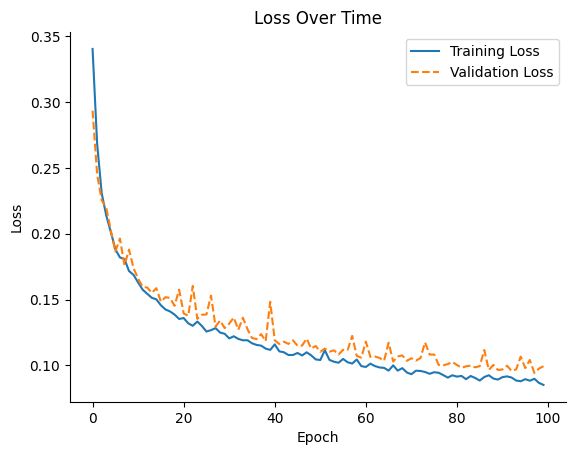

37/37 [==============================] - 0s 2ms/step


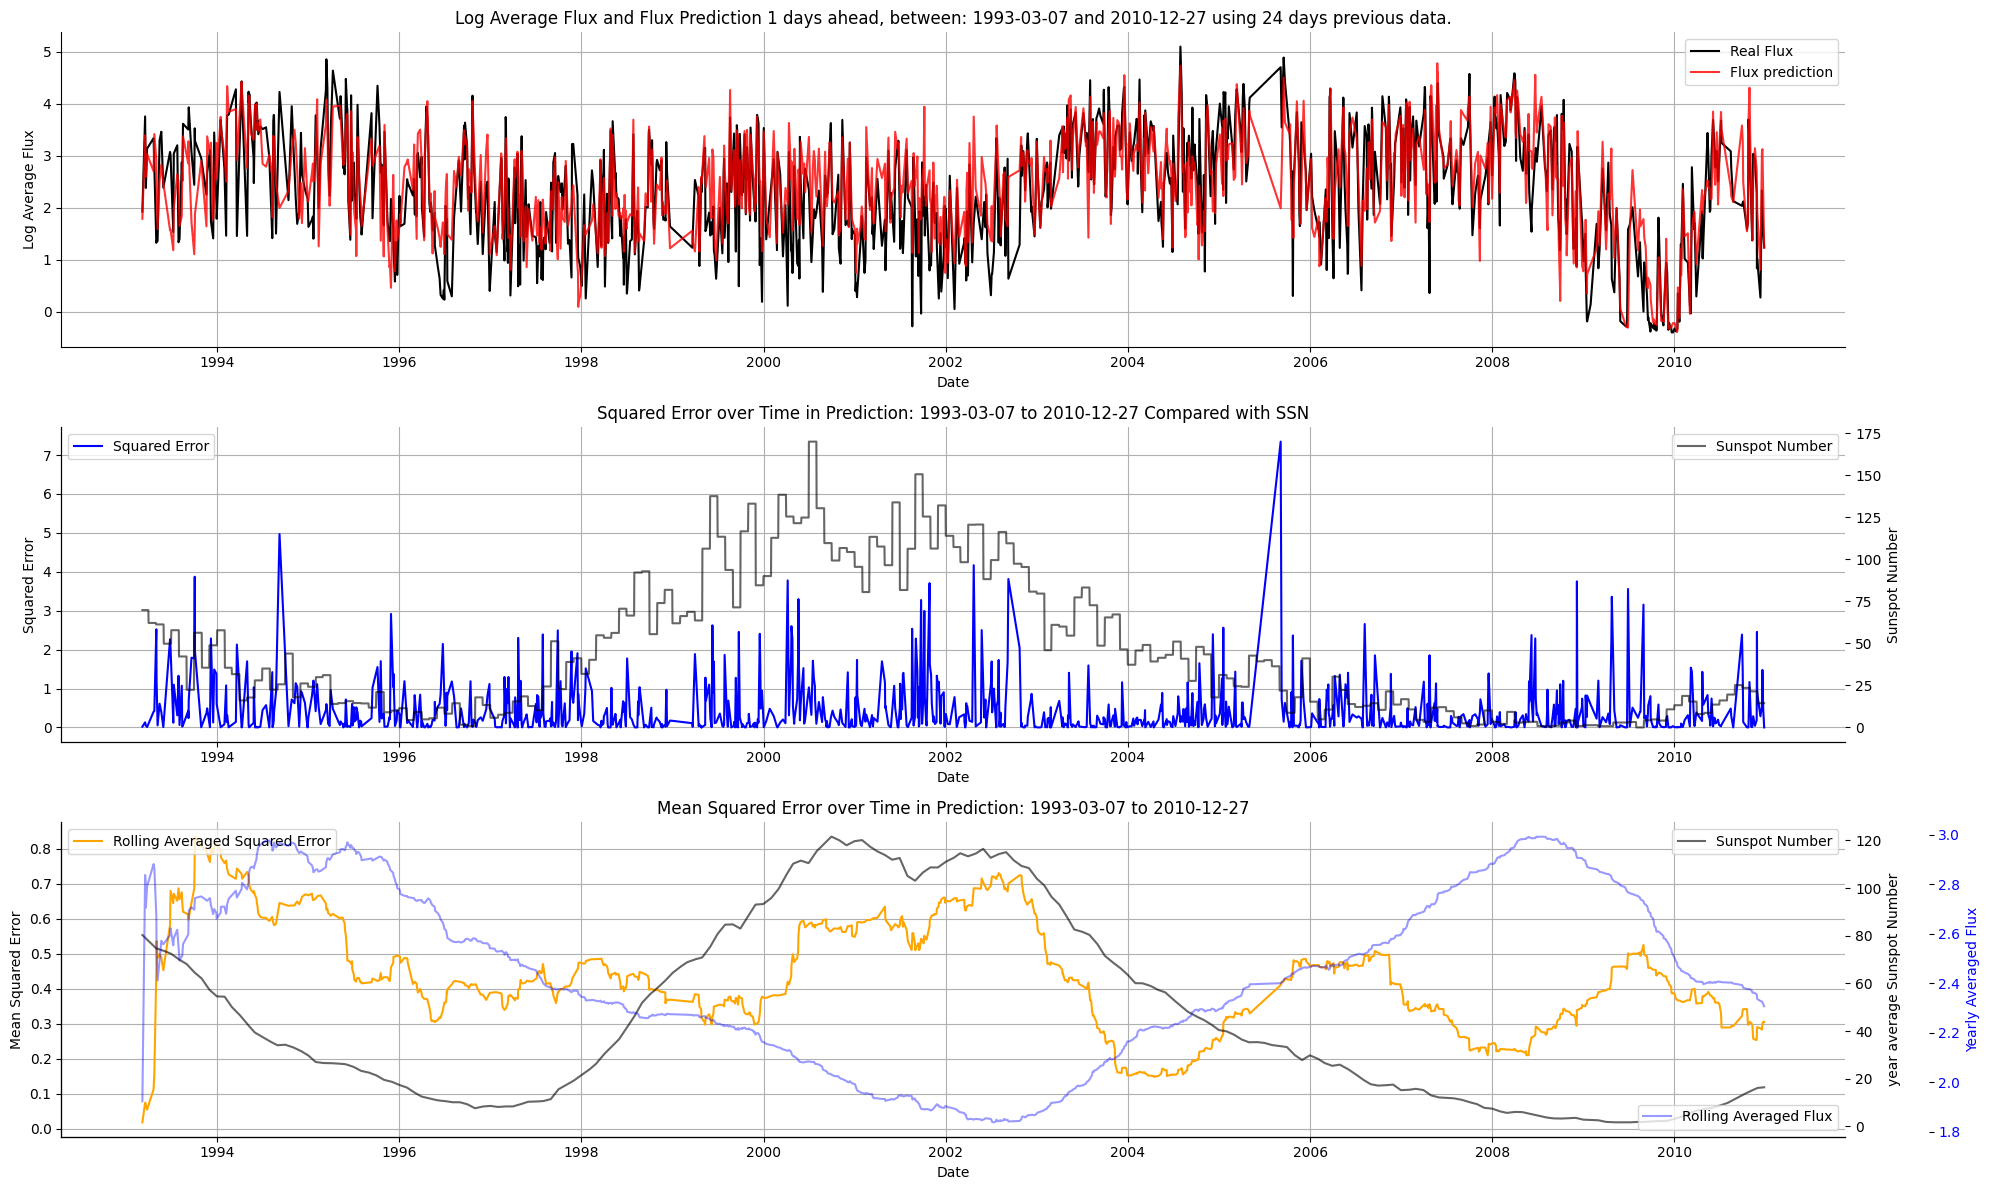

PE:
0.6723664532246685
MSE:
0.4168044905475513


(0.6723664532246685, 0.4168044905475513)

In [ ]:

m1 = main(file_path = '/content/drive/MyDrive/4th year/diss/Data_for_FYP/Energetic particle sensor/GOES_comb/GOES_1992_2010')
m1.FFNN_compile(
    days_ahead=1,
    back_log=24,
    AR=False,
    learn_rate=0.0007
    )
m1.NN_train(epoch_num=100, batch_num=100, visible = 1, is_saved=False)
m1.NN_predict()
m1.graph_with_error()
m1.validate()

In [ ]:
m1.validate()

PE:
0.8540256797062413
MSE:
0.18095887435297509


(0.8540256797062413, 0.18095887435297509)

In [ ]:
df = m1.df_graph
window_size = 80
window_size2 = 365
rolling_avg_squared_error = df['SquaredError'].rolling(window=window_size).mean()

# Step 2: Calculate rolling variance of 'log_Average_Flux'
rolling_var_log_avg_flux = df['log_Average_Flux'].rolling(window=window_size).var()

# Step 3: Plot the rolling averages on the same plot
plt.figure(figsize=(20, 4))

# rolling_avg_squared_error.plot(label='Rolling MSE', color='yellow')
# rolling_var_log_avg_flux.plot(label='Rolling Var Log Average Flux', color='red')
sunspots_df = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/HelioSphere/ISSN_D_tot.csv')
sunspots_df['Date'] = pd.to_datetime(sunspots_df['Date'])
sunspots_df.set_index('Date', inplace=True)
# sunspots_df_resampled = sunspots_df.resample('3M').transform('mean')
sunspots_df_resampled = sunspots_df.rolling(window=window_size2, min_periods=1).mean()

# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Rolling Average SquaredError vs Rolling Variance Log Average Flux')
# plt.legend()
# plt.grid(True)
# plt.show()

<Figure size 2000x400 with 0 Axes>

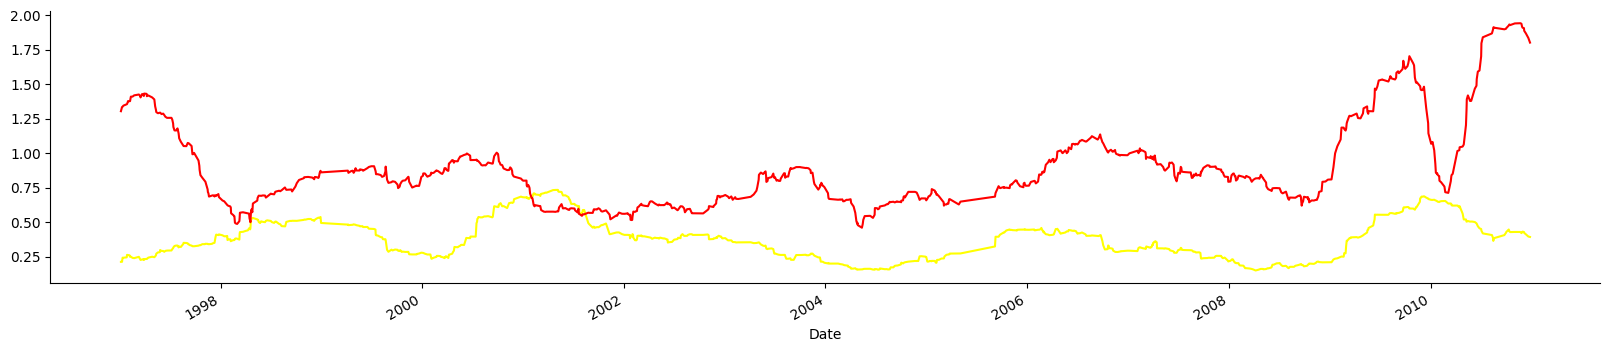

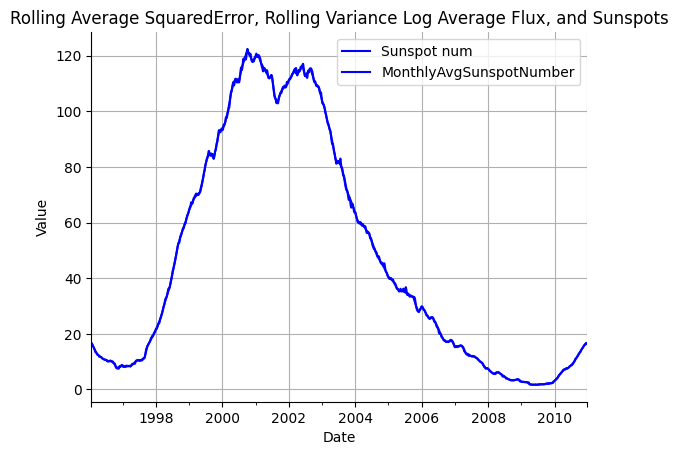

In [ ]:
# Step 1: Calculate rolling average of 'SquaredError'
rolling_avg_squared_error = df['SquaredError'].rolling(window=window_size).mean()

# Step 2: Calculate rolling variance of 'log_Average_Flux'
rolling_var_log_avg_flux = df['log_Average_Flux'].rolling(window=window_size).var()

# Trim sunspots_df_resampled to match the index range of df
start_date = df.index[0]
end_date = df.index[-1]
trimmed_sunspots_df_resampled = sunspots_df_resampled[start_date:end_date]

# Step 3: Plot the rolling averages on the same plot
plt.figure(figsize=(20, 4))

rolling_avg_squared_error.plot(label='Rolling MSE', color='yellow')
rolling_var_log_avg_flux.plot(label='Rolling Var Log Average Flux', color='red')
trimmed_sunspots_df_resampled.plot(label='Sunspots', color='blue')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Rolling Average SquaredError, Rolling Variance Log Average Flux, and Sunspots')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sunspots_df_resampled
sunspots_df_resampled

KeyError: "['\\tSunspot num\\t'] not found in axis"

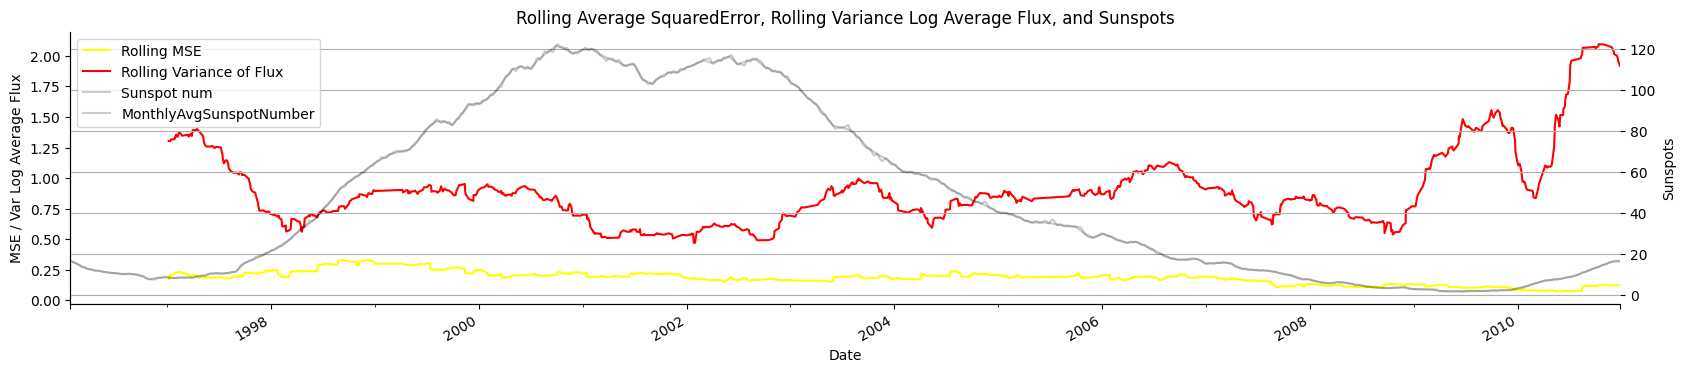

In [ ]:
# Step 1: Calculate rolling average of 'SquaredError'
rolling_avg_squared_error = df['SquaredError'].rolling(window=window_size).mean()

# Step 2: Calculate rolling variance of 'log_Average_Flux'
rolling_var_log_avg_flux = df['log_Average_Flux'].rolling(window=window_size).var()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 4))

# Plot rolling averages on the same axis
rolling_avg_squared_error.plot(ax=ax, label='Rolling MSE', color='yellow')
rolling_var_log_avg_flux.plot(ax=ax, label='Rolling Variance of Flux', color='red')

# Trim sunspots_df_resampled to match the index range of df
start_date = df.index[0]
end_date = df.index[-1]
trimmed_sunspots_df_resampled = sunspots_df_resampled[start_date:end_date]

# Plot the trimmed sunspots data on a separate axis
ax2 = ax.twinx()
trimmed_sunspots_df_resampled.plot(ax=ax2, label='Sunspots', color='black', alpha=0.2)

# Combine the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('MSE / Var Log Average Flux')
ax2.set_ylabel('Sunspots')
plt.title('Rolling Average SquaredError, Rolling Variance Log Average Flux, and Sunspots')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
m1.validate()

PE:
0.7010233238977438
MSE:
0.37179086194311467


(0.7010233238977438, 0.37179086194311467)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (24,) + inhomogeneous part.

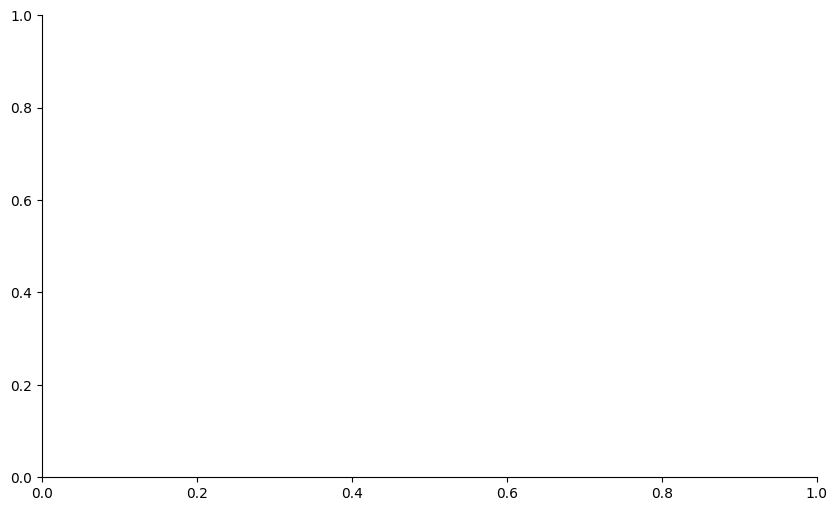

In [ ]:
data = {
    'PE': [0.81,0.59,0.52,0.69,0.84,0.81,0.85,0.52,0.91,0.76,0.85,0.5,0.7,0.79,0.5,0.72,0.79,0.6,0.71,0.83,0.82,0.71,0.53,0.91],
    'Start_Year': [1995,1995,1998,1995,1995,1995,1995,1982,1995,2000,1995,2000,2011,2010,1994,1992,2001,1978,1998,2011,1992,1992,1992,1992],
    'End_Year': [1997,2000,1999,2000,2000,2000,2000,1986,1996,2001,1996,2001,2013,2013,2000,2007,2007,1995,2009,2018,2011,2011,2011,2011]
}
df = pd.DataFrame(data)

# Prepare data for plotting
plot_data = []
for index, row in df.iterrows():
    start_year = int(row['Start_Year'])
    end_year = int(row['End_Year'])
    years = list(range(start_year, end_year + 1))
    values = [row['PE']] * len(years)
    plot_data.append(pd.Series(values, index=years))

# Create stacked area plot
plt.figure(figsize=(10, 6))
plt.stackplot(plot_data[0].index, plot_data, labels=df['PE'])
plt.xlabel('Year')
plt.ylabel('PE')
plt.title('Stacked Area Plot of Values Over Time')
plt.legend(title='Value')
plt.grid(True)
plt.show()

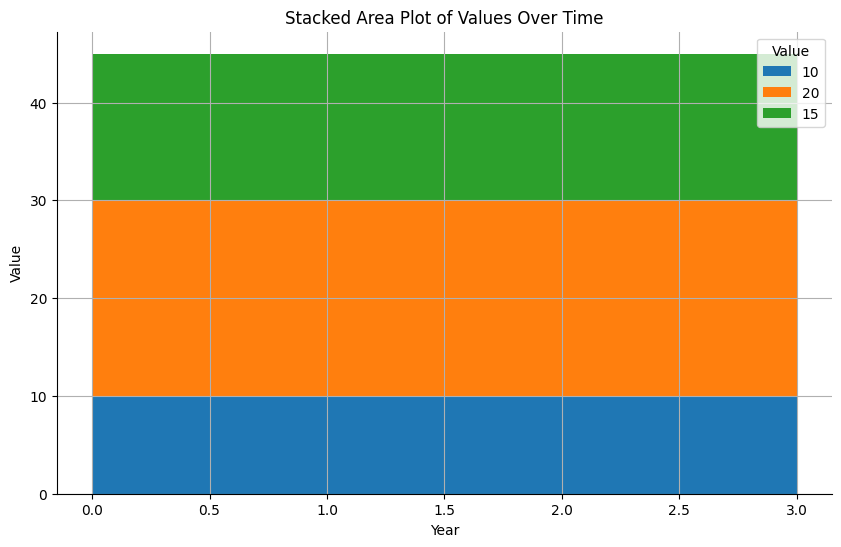

In [ ]:
# Example DataFrame with value, starting year, and ending year columns
data = {
    'Value': [10, 20, 15],
    'Start_Year': [2000, 2002, 2001],
    'End_Year': [2003, 2005, 2004]
}
df = pd.DataFrame(data)

# Prepare data for plotting
plot_data = []
for index, row in df.iterrows():
    start_year = int(row['Start_Year'])
    end_year = int(row['End_Year'])
    values = [row['Value']] * (end_year - start_year + 1)
    years = list(range(start_year, end_year + 1))
    plot_data.append(pd.Series(values, index=years))

# Interpolate the data to have the same length for each sequence
max_length = max(len(series) for series in plot_data)
for i in range(len(plot_data)):
    series_length = len(plot_data[i])
    if series_length < max_length:
        last_value = plot_data[i].iloc[-1]
        for j in range(max_length - series_length):
            plot_data[i] = plot_data[i].append(pd.Series([last_value], index=[plot_data[i].index[-1] + 1]))

# Create stacked area plot
plt.figure(figsize=(10, 6))
plt.stackplot(range(max_length), plot_data, labels=df['Value'])
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Stacked Area Plot of Values Over Time')
plt.legend(title='Value')
plt.grid(True)
plt.show()

In [ ]:
m1 = main(file_path = '/content/drive/MyDrive/4th year/diss/Res_study/GOES_low_en.csv')

In [ ]:
m1 = main(file_path = '/content/drive/MyDrive/4th year/diss/Res_study/GOES_mid_en.csv')

In [ ]:
m1.custom_prmtr_rng()

log_Average_Flux include this parameter (y/n) if the flux value respond (f)? f
Energy Channel of log_Average_Flux (float) MeV?2
Include MAG_AVG_B-VECTOR_nT as a parameter (y/n)? y
Include BY__GSM_nT as a parameter (y/n)? n
Include BZ__GSM_nT as a parameter (y/n)? y
Include RMS_SD_B_SCALAR_nT as a parameter (y/n)? y
Include FLOW_SPEED__GSE_km/s as a parameter (y/n)? y
Include VX_VELOCITY__GSE_km/s as a parameter (y/n)? n
Include VY_VELOCITY__GSE_km/s as a parameter (y/n)? n
Include VZ_VELOCITY__GSE_km/s as a parameter (y/n)? n
Include PROTON_DENSITY_n/cc as a parameter (y/n)? y
Include TEMPERATURE_K as a parameter (y/n)? y
Include FLOW_PRESSURE_nPa as a parameter (y/n)? y
Include ELECTRIC_FIELD_mV/m as a parameter (y/n)? y
Include ALFVEN_MACH_NO._ as a parameter (y/n)? n
Include X_(S/C)__GSE_Re as a parameter (y/n)? n
Include Y_(S/C)__GSE_Re as a parameter (y/n)? n
Include Z_(S/C)__GSE_Re as a parameter (y/n)? n
Include X_(BSN)__GSE_Re as a parameter (y/n)? n
Include Y_(BSN)__GSE_Re as 

In [ ]:
m1.validate()

PE:
0.4297418052357247
MSE:
0.19264115648690142


(0.4297418052357247, 0.19264115648690142)

In [ ]:
m1.NARMAX(days_ahead=1, back_log=15, polynomial_deg=2)
m1.graph_with_error()

KeyboardInterrupt: 

Epoch 1/1000
47/47 [==============================] - 1s 6ms/step - loss: 0.2078 - mae: 0.2078 - val_loss: 0.1665 - val_mae: 0.1665
Epoch 2/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1571 - mae: 0.1571 - val_loss: 0.1497 - val_mae: 0.1497
Epoch 3/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1424 - mae: 0.1424 - val_loss: 0.1399 - val_mae: 0.1399
Epoch 4/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1332 - mae: 0.1332 - val_loss: 0.1314 - val_mae: 0.1314
Epoch 5/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1285 - mae: 0.1285 - val_loss: 0.1288 - val_mae: 0.1288
Epoch 6/1000
47/47 [==============================] - 0s 4ms/step - loss: 0.1255 - mae: 0.1255 - val_loss: 0.1255 - val_mae: 0.1255
Epoch 7/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1222 - mae: 0.1222 - val_loss: 0.1223 - val_mae: 0.1223
Epoch 8/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.

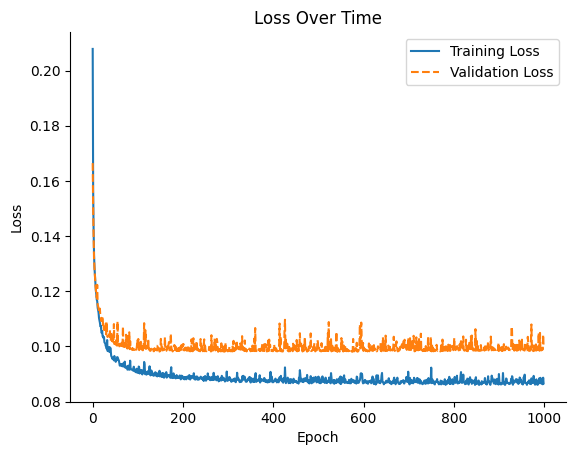

37/37 [==============================] - 0s 1ms/step


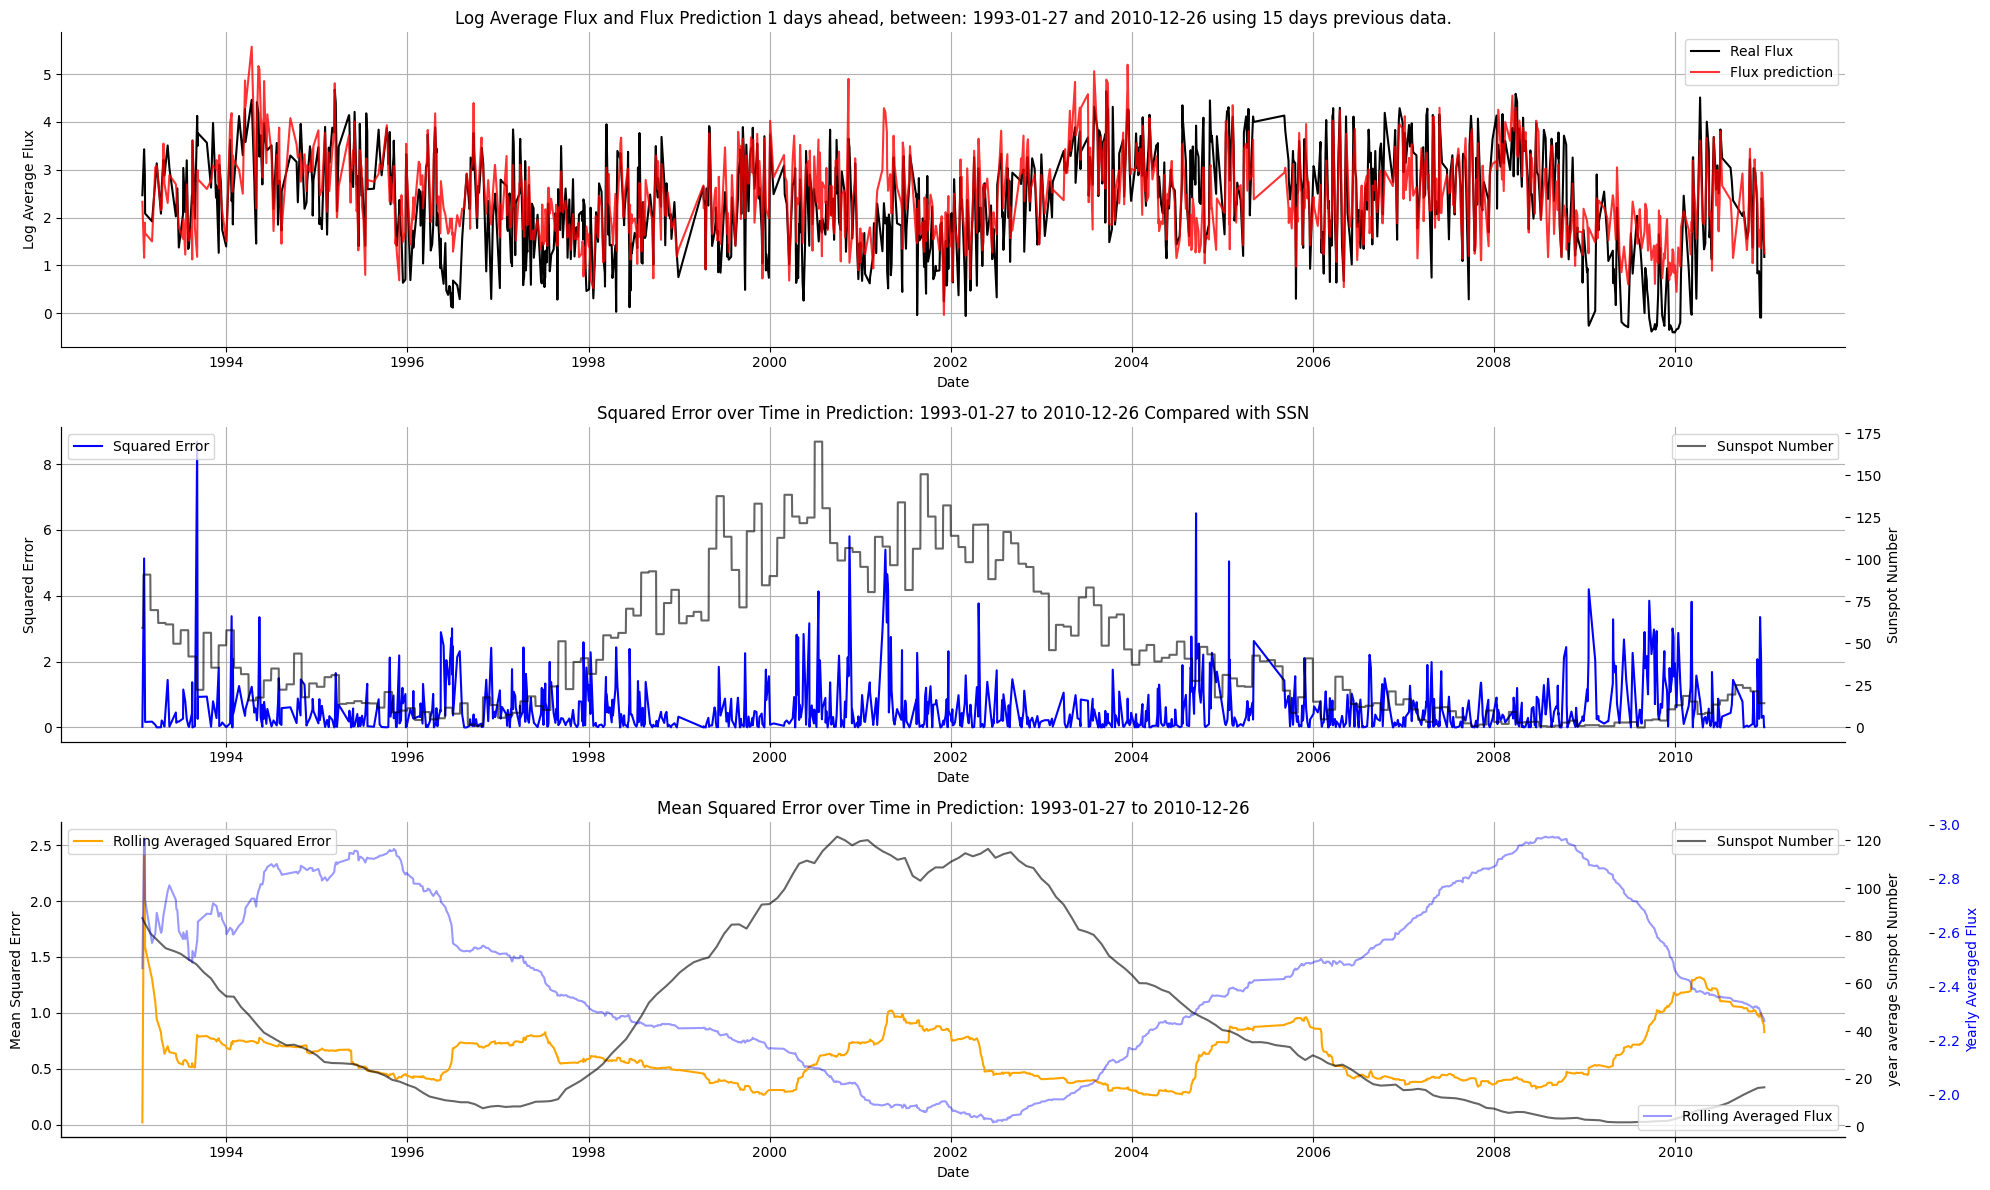

In [ ]:
m1.FFNN_compile(
    days_ahead=1,
    back_log=15,
    AR=False,
    learn_rate=0.0007,
    Architecture = []
    )
m1.NN_train(epoch_num=1000, batch_num=100, visible = 1, is_saved=False)
m1.NN_predict()
m1.graph_with_error()

Epoch 1/100
6/6 [==============================] - 1s 48ms/step - loss: 0.3500 - mae: 0.2450 - val_loss: 0.4451 - val_mae: 0.3410
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3101 - mae: 0.2065 - val_loss: 0.3595 - val_mae: 0.2567
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2607 - mae: 0.1585 - val_loss: 0.3409 - val_mae: 0.2394
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.2371 - mae: 0.1361 - val_loss: 0.3241 - val_mae: 0.2239
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2314 - mae: 0.1317 - val_loss: 0.3184 - val_mae: 0.2194
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.2156 - mae: 0.1171 - val_loss: 0.2945 - val_mae: 0.1966
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.2001 - mae: 0.1028 - val_loss: 0.2923 - val_mae: 0.1956
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1857 - mae: 0.0894 -

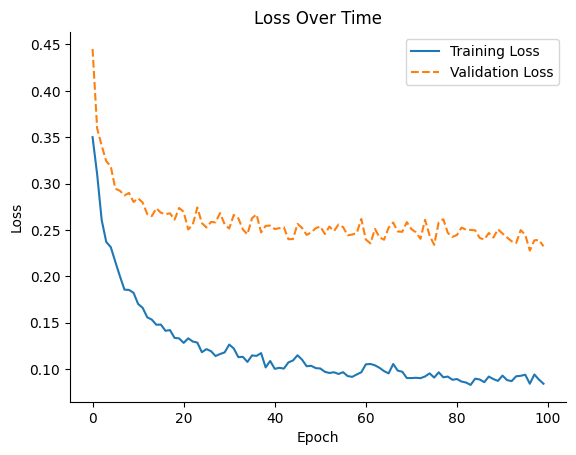

1/1 [==============================] - 0s 67ms/step


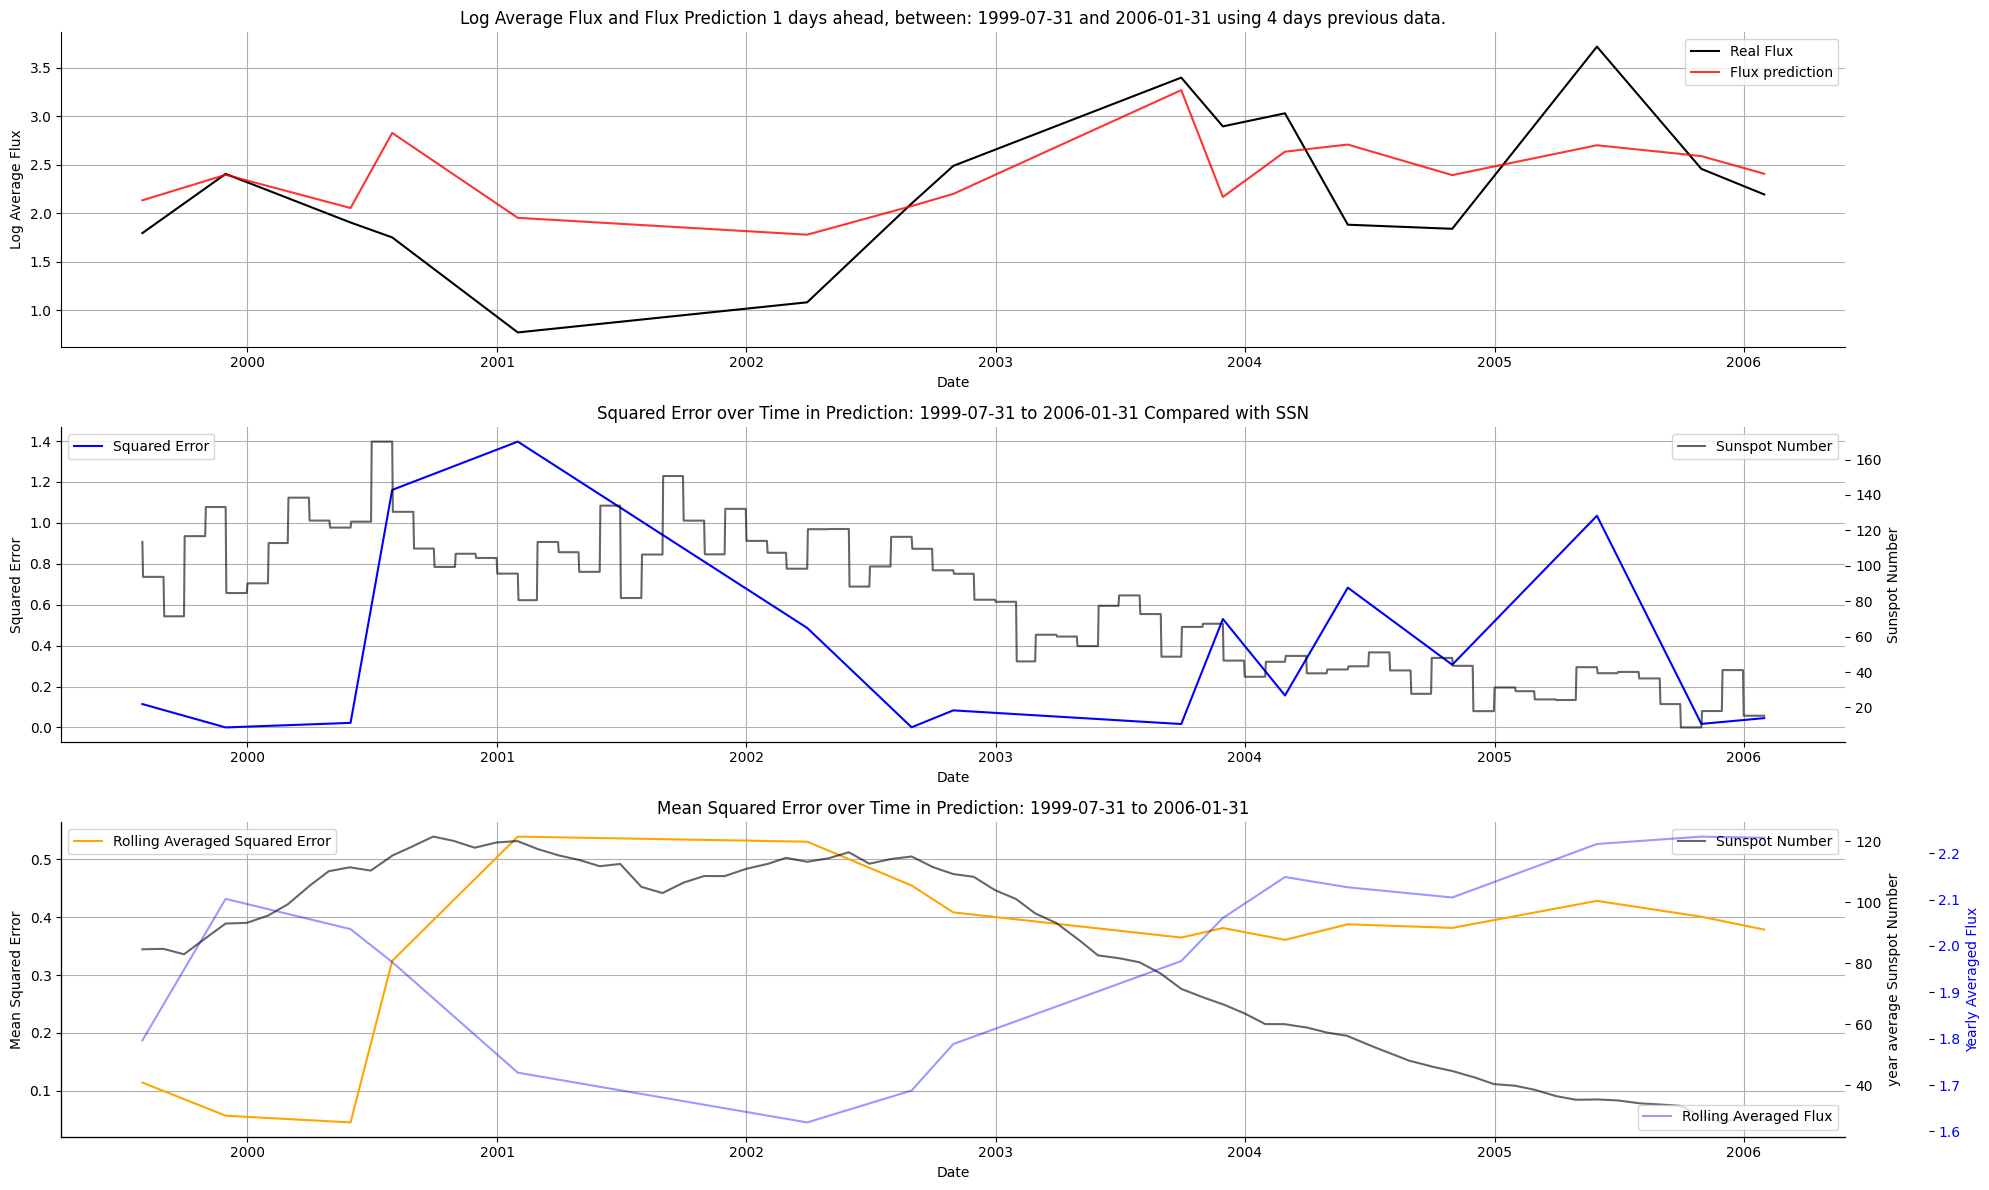

PE:
0.37480319653085614
MSE:
0.3785082740315223


In [ ]:
PE_list2 = []
# back_logs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# for i in back_logs:
m1 = main(file_path = '/content/drive/MyDrive/4th year/diss/Res_study/GOES_mid_en.csv', resolution='M')
m1.FFNN_compile(days_ahead=1, back_log=4, AR=False, learn_rate=0.0007)
m1.NN_train(epoch_num=100, batch_num=10, visible = 1, is_saved=False)
m1.NN_predict()
m1.graph_with_error()
PE, MSE = m1.validate()
PE_list2.append(PE)

In [ ]:
m1 = main(file_path = '/content/drive/MyDrive/4th year/diss/Data_for_FYP/Energetic particle sensor/GOES_comb/GOES_1992_2010')
m1.df

log_Average_Flux  MAG_AVG_B-VECTOR_nT  BY__GSM_nT  \
Date                                                                           
1992-12-15 00:00:00+00:00          0.759733             6.951319   -0.097143   
1992-12-16 00:00:00+00:00          1.249935             6.252067   -2.329267   
1992-12-17 00:00:00+00:00          1.544174            11.819386   -3.688070   
1992-12-21 00:00:00+00:00          1.291471             8.636957    5.568841   
1992-12-22 00:00:00+00:00          0.766079             5.054000    0.580273   
...                                     ...                  ...         ...   
2010-12-26 00:00:00+00:00          1.178586             5.012649    1.467052   
2010-12-27 00:00:00+00:00          1.239178             3.963832    0.692518   
2010-12-28 00:00:00+00:00          0.842706             7.947029    4.759674   
2010-12-29 00:00:00+00:00         -0.315685             4.050978    2.361304   
2010-12-30 00:00:00+00:00         -0.336460             4.933804    3.803080   

                           BZ__GSM_nT  RMS_SD_B_SCALAR_nT  \
Date                                                        
1992-12-15 00:00:00+00:00    1.128022            0.364725   
1992-12-16 00:00:00+00:00    1.127600            0.250933   
1992-12-17 00:00:00+00:00    0.630351            0.246140   
1992-12-21 00:00:00+00:00   -0.425652            0.132754   
1992-12-22 00:00:00+00:00    0.341727            0.262273   
...                               ...                 ...   
2010-12-26 00:00:00+00:00    1.013433            0.090075   
2010-12-27 00:00:00+00:00   -0.252591            0.074635   
2010-12-28 00:00:00+00:00   -0.513696            0.202174   
2010-12-29 00:00:00+00:00   -0.039058            0.121920   
2010-12-30 00:00:00+00:00   -0.111775            0.121486   

                           FLOW_SPEED__GSE_km/s  VX_VELOCITY__GSE_km/s  \
Date                                                                     
1992-12-15 00:00:00+00:00            531.475824            -528.314286   
1992-12-16 00:00:00+00:00            442.740000            -441.778667   
1992-12-17 00:00:00+00:00            441.522807            -438.850000   
1992-12-21 00:00:00+00:00            511.701449            -510.755072   
1992-12-22 00:00:00+00:00            519.320909            -518.481818   
...                                         ...                    ...   
2010-12-26 00:00:00+00:00            394.087313            -390.203358   
2010-12-27 00:00:00+00:00            352.285766            -349.042701   
2010-12-28 00:00:00+00:00            346.252174            -344.246739   
2010-12-29 00:00:00+00:00            375.164855            -371.952536   
2010-12-30 00:00:00+00:00            336.016667            -335.295290   

                           VY_VELOCITY__GSE_km/s  VZ_VELOCITY__GSE_km/s  \
Date                                                                      
1992-12-15 00:00:00+00:00              26.778022             -35.460440   
1992-12-16 00:00:00+00:00              -1.684000             -14.420000   
1992-12-17 00:00:00+00:00             -15.382456              -7.862281   
1992-12-21 00:00:00+00:00              -9.540580              -2.326087   
1992-12-22 00:00:00+00:00             -14.820909              13.208182   
...                                          ...                    ...   
2010-12-26 00:00:00+00:00              32.102985             -40.648507   
2010-12-27 00:00:00+00:00               7.024818             -37.319708   
2010-12-28 00:00:00+00:00              10.293478              -3.678623   
2010-12-29 00:00:00+00:00              36.935145             -25.360870   
2010-12-30 00:00:00+00:00               0.299638             -18.371739   

                           PROTON_DENSITY_n/cc  ...  Z_(S/C)__GSE_Re  \
Date                                            ...                    
1992-12-15 00:00:00+00:00             6.373626  ...        12.373407   
1992-12-16 00:00:00+00:00            

In [ ]:
print(PE_list)

[0.16407211347355544, 0.44155722474741277, 0.7495798911822922, 0.6763444293873084, 0.6329072832243441, 0.465354127963171, 0.5872153322819268, 0.7654371436674383, 0.6819403770497645, 0.6202576621391753]


In [ ]:
print(PE_list2)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.3225 - mae: 1.2280 - val_loss: 1.7479 - val_mae: 1.6537
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 1.1333 - mae: 1.0391 - val_loss: 1.6014 - val_mae: 1.5074
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.9498 - mae: 0.8558 - val_loss: 1.4527 - val_mae: 1.3589
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 0.7911 - mae: 0.6973 - val_loss: 1.3311 - val_mae: 1.2375
Epoch 5/100
1/1 [==============================] - 0s 42ms/step - loss: 0.7057 - mae: 0.6121 - val_loss: 1.2278 - val_mae: 1.1344
Epoch 6/100
1/1 [==============================] - 0s 40ms/step - loss: 0.6244 - mae: 0.5310 - val_loss: 1.1019 - val_mae: 1.0088
Epoch 7/100
1/1 [==============================] - 0s 42ms/step - loss: 0.5429 - mae: 0.4497 - val_loss: 0.9813 - val_mae: 0.8883
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 0.4641 - mae: 0.3711

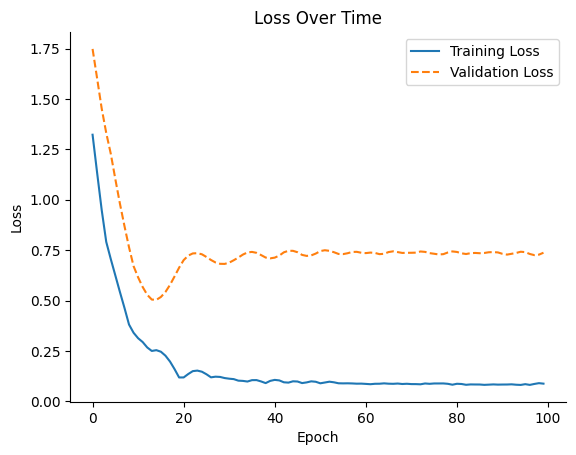

1/1 [==============================] - 0s 92ms/step


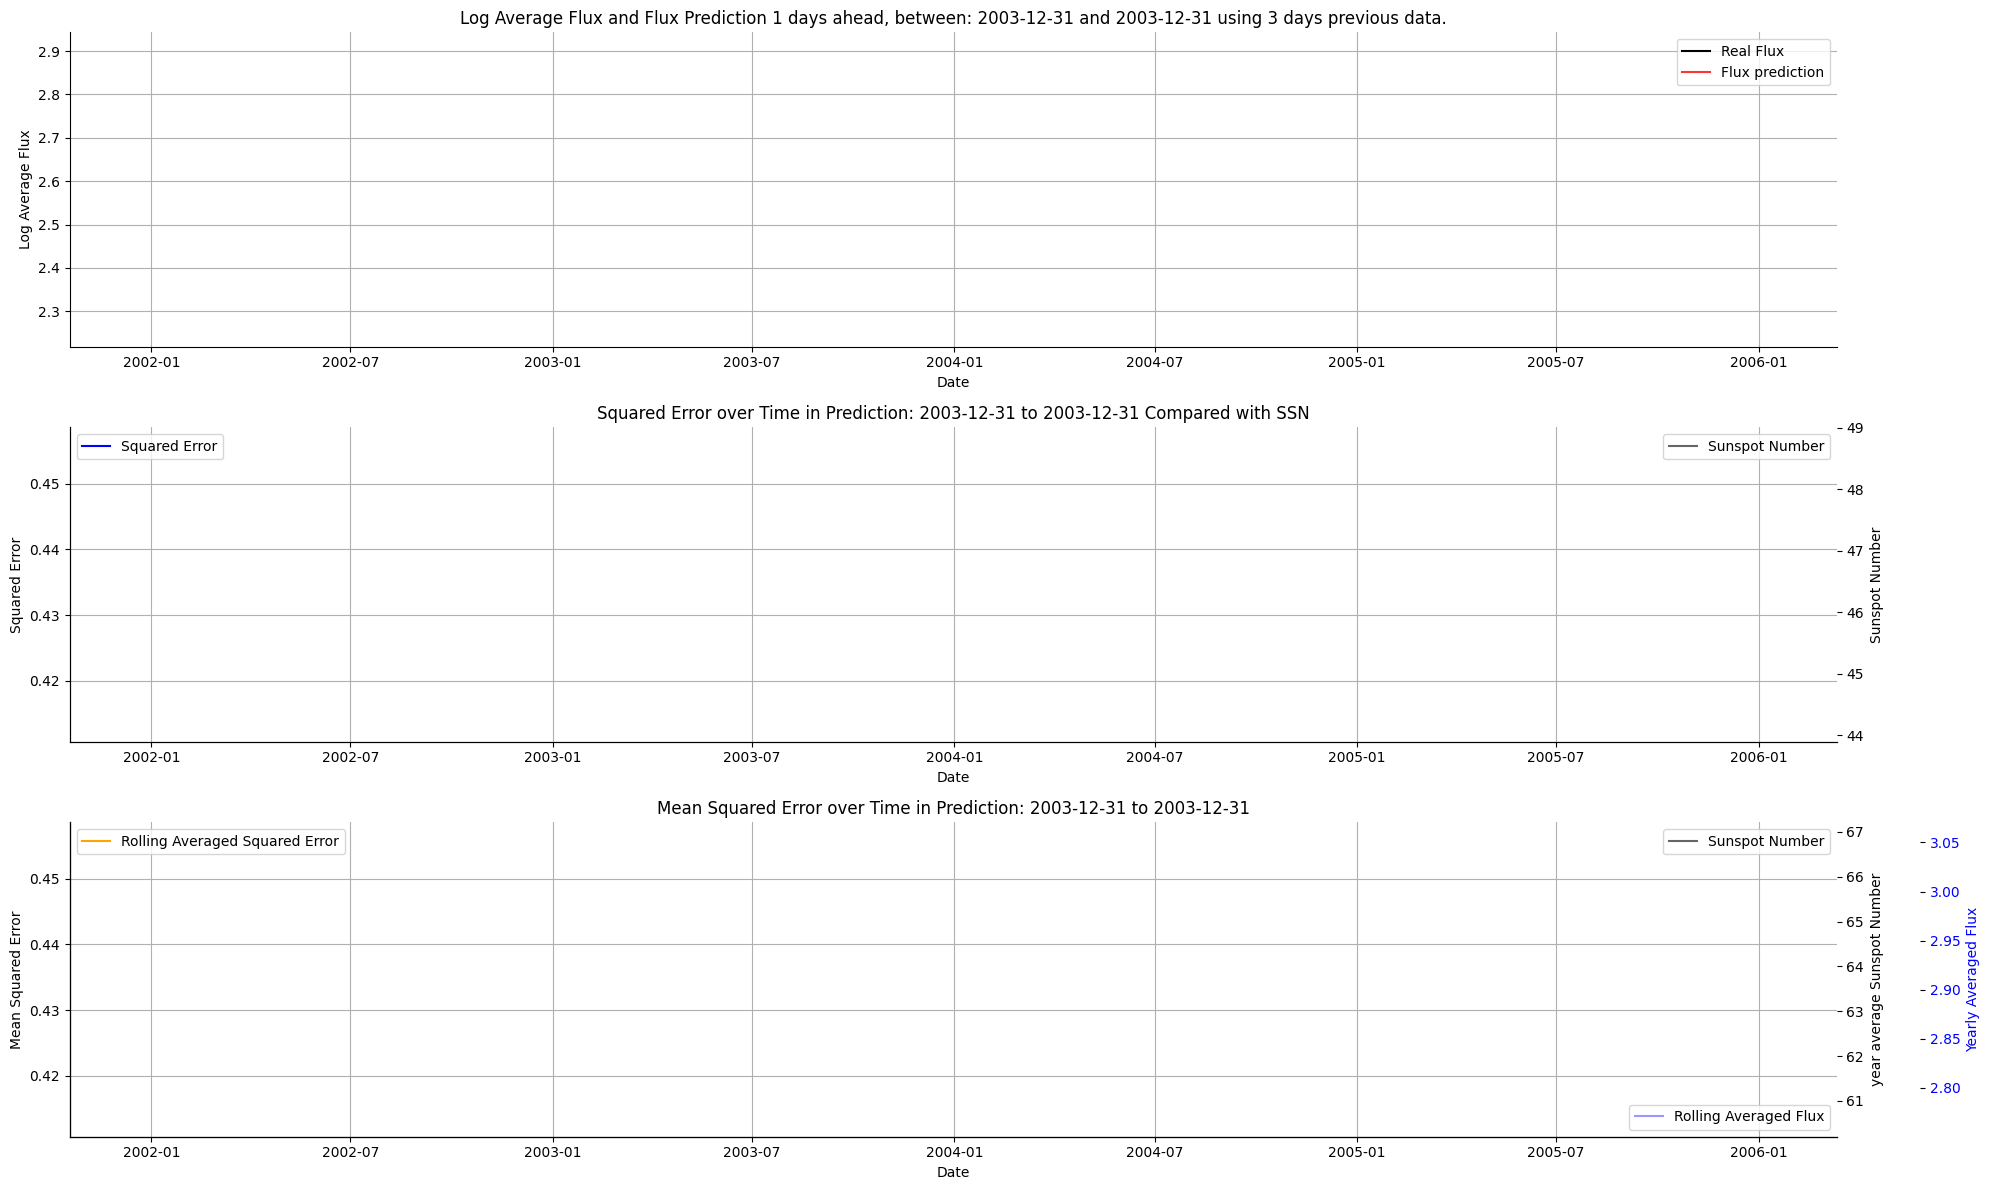

PE:
nan
MSE:
0.43464702917240916


In [ ]:
PE_list2 = []
back_logs = ['300S', '600S', '1800S', 'H', '6H', '12H', 'D', '5D', '10D', 'M', 'Y']
for i in back_logs:
  m1 = main(file_path = '/content/drive/MyDrive/4th year/diss/Res_study/GOES_mid_en.csv', resolution=i)
  m1.FFNN_compile(days_ahead=1, back_log=10, AR=False, learn_rate=0.0007)
  m1.NN_train(epoch_num=100, batch_num=50, visible = 1, is_saved=False)
  m1.NN_predict()
  m1.graph_with_error()
  PE, MSE = m1.validate()
  PE_list2.append(PE)

In [ ]:
sunspots_df = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/HelioSphere/ISSN_D_tot.csv')
sunspots_df['Date'] = pd.to_datetime(sunspots_df['Date'])
sunspots_df.set_index('Date', inplace=True)
# sunspots_df_resampled = sunspots_df.resample('3M').transform('mean')
window_size=365
sunspots_df_resampled = sunspots_df.rolling(window=window_size, min_periods=1).mean()
start_date = Timestamp(datetime(1992, 12, 15), tz='UTC')
end_date = Timestamp(datetime(2010, 12, 30), tz='UTC')
df_subset = sunspots_df_resampled[(sunspots_df_resampled.index >= start_date) & (sunspots_df_resampled.index <= end_date)]

In [ ]:
df_subset

Sunspot num  MonthlyAvgSunspotNumber
Date                                                           
1992-12-15 00:00:00+00:00    96.219178                96.847901
1992-12-16 00:00:00+00:00    96.178082                96.678568
1992-12-17 00:00:00+00:00    96.101370                96.509236
1992-12-18 00:00:00+00:00    96.002740                96.339903
1992-12-19 00:00:00+00:00    95.947945                96.170570
...                                ...                      ...
2010-12-26 00:00:00+00:00    16.446575                16.415820
2010-12-27 00:00:00+00:00    16.446575                16.425806
2010-12-28 00:00:00+00:00    16.449315                16.435793
2010-12-29 00:00:00+00:00    16.446575                16.445780
2010-12-30 00:00:00+00:00    16.435616                16.455767

[6590 rows x 2 columns]

from matplotlib import pyplot as plt
df_subset['Sunspot num'].plot(kind='hist', bins=20, title='Sunspot num')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_subset['MonthlyAvgSunspotNumber'].plot(kind='hist', bins=20, title='MonthlyAvgSunspotNumber')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_subset.plot(kind='scatter', x='Sunspot num', y='MonthlyAvgSunspotNumber', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_subset['Sunspot num'].plot(kind='line', figsize=(8, 4), title='Sunspot num')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_subset['MonthlyAvgSunspotNumber'].plot(kind='line', figsize=(8, 4), title='MonthlyAvgSunspotNumber')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# dates_array = ['2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04']
dates_array = ['1994-01-01', '1995-01-01','1997-01-01','1999-01-01','2001-01-01', '2003-01-01', '2005-01-01', '2007-01-01', '2009-01-01', '2010-01-01']
# Convert array of dates to pandas datetime objects with zeros for the time component
dates_index = [pd.Timestamp(date) for date in dates_array]

# Create DataFrame with date index
df = pd.DataFrame(index=dates_index)
df['PE_FCNN'] = [0.03, 0.47, 0.69, 0.53, 0.61, 0.39, 0.46, 0.65, 0.61, 0.70]
df['PE_LPF_'] = [-0.12,0.07,0.58,0.46,0.31,0.07,0.30,0.52,0.47,-1.06]
df['PE_RNN_'] = [0.16,0.44,0.75,0.68,0.63,0.47,0.59,0.77,0.68,0.62]
df

PE_FCNN  PE_LPF_  PE_RNN_
1994-01-01     0.03    -0.12     0.16
1995-01-01     0.47     0.07     0.44
1997-01-01     0.69     0.58     0.75
1999-01-01     0.53     0.46     0.68
2001-01-01     0.61     0.31     0.63
2003-01-01     0.39     0.07     0.47
2005-01-01     0.46     0.30     0.59
2007-01-01     0.65     0.52     0.77
2009-01-01     0.61     0.47     0.68
2010-01-01     0.70    -1.06     0.62

In [ ]:
df_subset.index = df_subset.index.tz_localize(None)
df.index = df.index.tz_localize(None)

# Concatenate the DataFrames
combined_df = pd.concat([df_subset, df], axis=1)
combined_df

Sunspot num  MonthlyAvgSunspotNumber  PE_FCNN  PE_LPF_  PE_RNN_
1992-12-15    96.219178                96.847901      NaN      NaN      NaN
1992-12-16    96.178082                96.678568      NaN      NaN      NaN
1992-12-17    96.101370                96.509236      NaN      NaN      NaN
1992-12-18    96.002740                96.339903      NaN      NaN      NaN
1992-12-19    95.947945                96.170570      NaN      NaN      NaN
...                 ...                      ...      ...      ...      ...
2010-12-26    16.446575                16.415820      NaN      NaN      NaN
2010-12-27    16.446575                16.425806      NaN      NaN      NaN
2010-12-28    16.449315                16.435793      NaN      NaN      NaN
2010-12-29    16.446575                16.445780      NaN      NaN      NaN
2010-12-30    16.435616                16.455767      NaN      NaN      NaN

[6590 rows x 5 columns]

from matplotlib import pyplot as plt
combined_df['Sunspot num'].plot(kind='hist', bins=20, title='Sunspot num')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combined_df['MonthlyAvgSunspotNumber'].plot(kind='hist', bins=20, title='MonthlyAvgSunspotNumber')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combined_df['PE_FCNN'].plot(kind='hist', bins=20, title='PE_FCNN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combined_df['PE_LPF_'].plot(kind='hist', bins=20, title='PE_LPF_')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combined_df.plot(kind='scatter', x='Sunspot num', y='MonthlyAvgSunspotNumber', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combined_df.plot(kind='scatter', x='MonthlyAvgSunspotNumber', y='PE_FCNN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combined_df.plot(kind='scatter', x='PE_FCNN', y='PE_LPF_', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combined_df.plot(kind='scatter', x='PE_LPF_', y='PE_RNN_', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
combined_df['Sunspot num'].plot(kind='line', figsize=(8, 4), title='Sunspot num')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
combined_df['MonthlyAvgSunspotNumber'].plot(kind='line', figsize=(8, 4), title='MonthlyAvgSunspotNumber')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
combined_df['PE_FCNN'].plot(kind='line', figsize=(8, 4), title='PE_FCNN')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
combined_df['PE_LPF_'].plot(kind='line', figsize=(8, 4), title='PE_LPF_')
plt.gca().spines[['top', 'right']].set_visible(False)

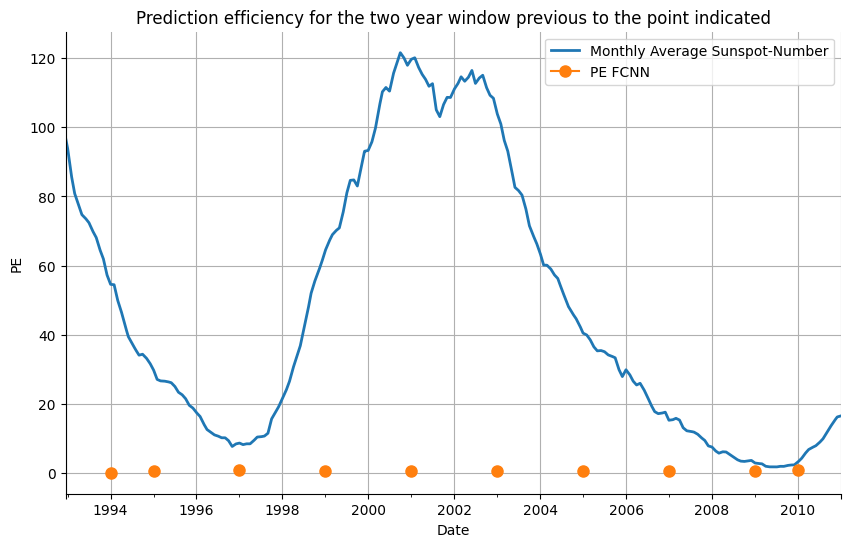

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the larger DataFrame as a line without points
combined_df['MonthlyAvgSunspotNumber'].plot(label='Monthly Average Sunspot-Number', linewidth=2)

# Plot the smaller DataFrame as a line with points
combined_df['PE_FCNN'].plot(label='PE FCNN', marker='o', linestyle='-', markersize=8)

plt.xlabel('Date')
plt.ylabel('PE')
plt.title('Prediction efficiency for the two year window previous to the point indicated')
plt.legend()
plt.grid(True)
plt.show()

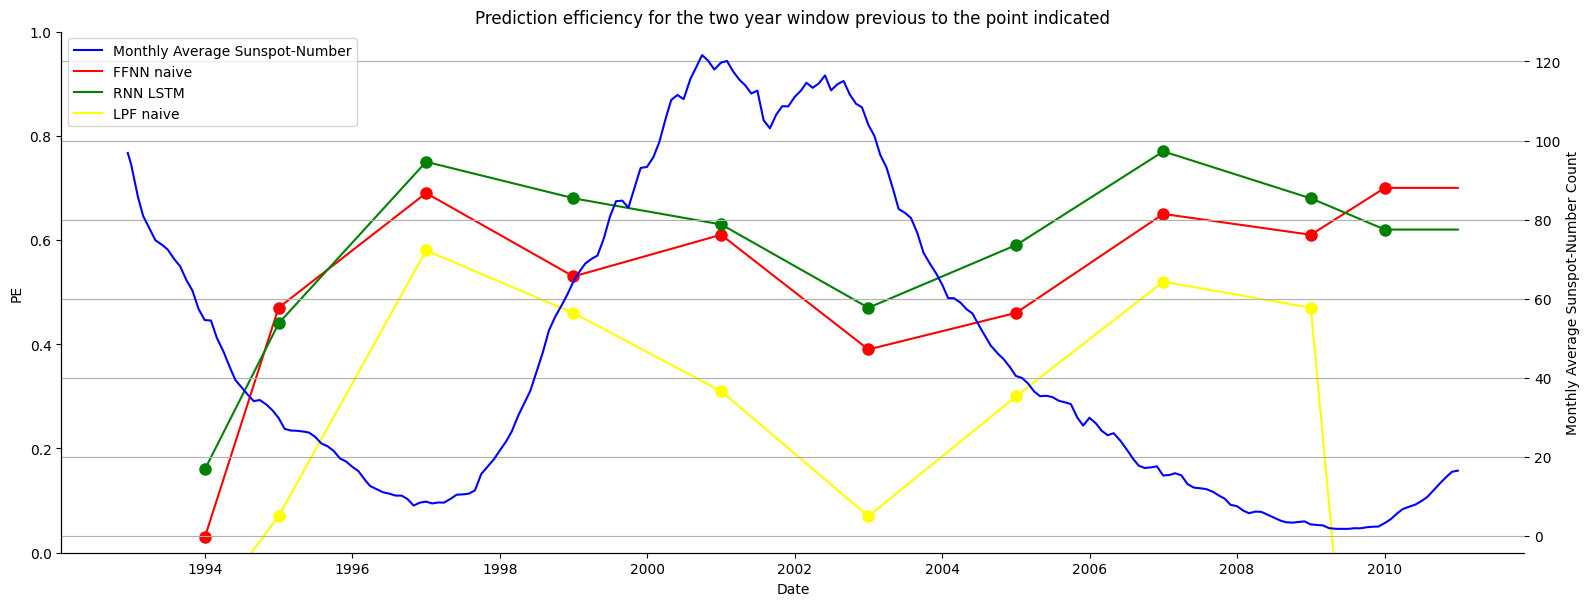

In [ ]:
# Interpolate NaN values
combined_df['PE_FFNN_interp'] = combined_df['PE_FCNN'].interpolate(method='time')
combined_df['PE_RNN_interp'] = combined_df['PE_RNN_'].interpolate(method='time')
combined_df['PE_LPF_interp'] = combined_df['PE_LPF_'].interpolate(method='time')
# Plotting
fig, ax2 = plt.subplots(figsize=(16, 6))

# Create a secondary y-axis for the smaller DataFrame's column
color = 'black'
ax2.set_xlabel('Date')
ax2.set_ylabel('PE', color='black')
ax2.plot(combined_df.index, combined_df['PE_FCNN'], color='red', linestyle='-', marker='o', markersize=8)
ax2.plot(combined_df.index, combined_df['PE_FFNN_interp'], color='red', linestyle='-', label='FFNN naive')
ax2.plot(combined_df.index, combined_df['PE_RNN_interp'], color='green', linestyle='-', label='RNN LSTM')
ax2.plot(combined_df.index, combined_df['PE_RNN_'], color='green', linestyle='-', marker='o', markersize=8)
ax2.plot(combined_df.index, combined_df['PE_LPF_interp'], color='yellow', linestyle='-', label='LPF naive')
ax2.plot(combined_df.index, combined_df['PE_LPF_'], color='yellow', linestyle='-', marker='o', markersize=8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.0)

# Plot the larger DataFrame's column on the primary y-axis
ax1 = ax2.twinx()
color = 'black'

ax1.set_ylabel('Monthly Average Sunspot-Number Count', color=color)
ax1.plot(combined_df.index, combined_df['MonthlyAvgSunspotNumber'], color='blue', label='Monthly Average Sunspot-Number')
ax1.tick_params(axis='y', labelcolor=color)

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()


fig.tight_layout()
plt.title('Prediction efficiency for the two year window previous to the point indicated')
plt.grid(True)
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

In [ ]:
back_logs = [4,5,6,7,8,9,10,11,12,13,14,15]
for i in PE_list:
  print(i)

0.11310611135982818
0.09611683498715251
0.12448194393286693
0.09989082341350297
0.13394387115538953
0.12173682828380161
0.1363679272224655
0.20513607229119923
0.17083219261168092
0.20213140316100675
0.1988248380966119
0.20113325063788967
0.26029905162757294
0.27840163323430744
0.20633077031023894


In [ ]:
df_high_en = pd.read_csv('/content/drive/MyDrive/4th year/diss/Res_study/GOES_high_en.csv')
df_low_en = pd.read_csv('/content/drive/MyDrive/4th year/diss/Res_study/GOES_low_en.csv')
df_mid_en = pd.read_csv('/content/drive/MyDrive/4th year/diss/Res_study/GOES_mid_en.csv')

In [ ]:
def conv_df_dt(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)
  df.dropna(inplace=True)
  def make_timezone_aware(df, timezone='UTC'):
    if df.index.tz is None:
          # If timezone-naive, localize to the specified timezone
          df.index = df.index.tz_localize(timezone)
      # Return the possibly modified DataFrame
    return df
  df = make_timezone_aware(df)
  return df
df_high_en = conv_df_dt(df_high_en)
df_low_en = conv_df_dt(df_low_en)
df_mid_en = conv_df_dt(df_mid_en)


In [ ]:
df_mid_en.min()

E2_(>2_MEV)_e/(cm^2*s*sr)   -1.000000e+31
dtype: float64

In [ ]:
min_value = -1.000000e+30
df_filtered_columns_2 = df_low_en[df_low_en['E1_(>0.6_MEV)_e/(cm^2*s*sr)'] >= min_value]


In [ ]:
df_filtered_columns.to_csv('/content/drive/MyDrive/4th year/diss/Res_study/GOES_mid_en.csv', index=True)

In [ ]:
df_filtered_columns_2.to_csv('/content/drive/MyDrive/4th year/diss/Res_study/GOES_low_en.csv', index=True)

In [ ]:
def convertlog_norm(flux):
  return 10 ** flux

def convert_cm2tom2(flux):
  return flux * 10000

def convert_log_10(x):
    """
    Safely compute the base-10 logarithm of x.
    Sets a lower bound to avoid logarithm of zero or negative numbers.
    """
    return np.log10(x)

df_filtered_columns[['log_Average_Flux_2mev']] = df_filtered_columns[['E2_(>2_MEV)_e/(cm^2*s*sr)']].apply(convert_log_10)
df_filtered_columns_2[['log_Average_Flux_600kev']] = df_filtered_columns_2[['E1_(>0.6_MEV)_e/(cm^2*s*sr)']].apply(convert_log_10)

In [ ]:
df_filtered_columns_2.drop(columns=['E1_(>0.6_MEV)_e/(cm^2*s*sr)'], inplace=True)
df_filtered_columns_2.min()

log_Average_Flux_600kev    0.343783
dtype: float64

In [ ]:
param_inter_str = 'Days_ahead_FFNN'
param_inter =[0,1,2,3,4,5,6,7,8,9,10]# [Architecture1, Architecture2, Architecture3, Architecture4, Architecture5]
param_weights = param_inter
PE_l, MSE_l = [], []
for i, w in zip(param_inter, param_weights):
  m1 = main('/content/drive/MyDrive/4th year/diss/Data_for_FYP/Energetic particle sensor/GOES_comb/GOES_1992_2010')
  m1.RNN_compile(days_ahead=1, back_log=10, AR=False, learn_rate=0.0007)
  m1.NN_train(epoch_num=i, batch_num=150, visible = 1, is_saved=True, arg_str = str(str(w) + param_inter_str))
  m1.NN_predict()
  m1.graph_with_error()
  PE, MSE = m1.validate()
  PE_l.append(PE)
  MSE_l.append(MSE)

df_gr = pd.DataFrame()
df_gr['PE'] = PE_l
df_gr['MSE'] = MSE_l
file_path_str = '/content/drive/MyDrive/4th year/diss/grid_search/PEs_MSEs/' + param_inter_str + '_grid'
df_gr.to_csv(file_path_str)

In [ ]:
days_ahead_list = [1, 2, 3, 4, 5, 10, 15, 20, 27, 50]
for i in days_ahead_list:
  m1 = main(file_path = '/content/drive/MyDrive/4th year/diss/Data_for_FYP/Energetic particle sensor/GOES_comb/GOES_1992_2010')
  main.delay_study_multiple(m1, prev_end = 1, all_delays = 9, steps_ahead = i, AR=False)

37/37 [==============================] - 0s 2ms/step
FFNN trained at one delay
37/37 [==============================] - 0s 2ms/step
FFNN trained at one delay
37/37 [==============================] - 0s 3ms/step
FFNN trained at one delay
37/37 [==============================] - 0s 1ms/step
FFNN trained at one delay
37/37 [==============================] - 0s 2ms/step
FFNN trained at one delay
37/37 [==============================] - 0s 2ms/step
FFNN trained at one delay
37/37 [==============================] - 0s 2ms/step
FFNN trained at one delay
37/37 [==============================] - 0s 2ms/step
FFNN trained at one delay
37/37 [==============================] - 0s 2ms/step
FFNN trained at one delay
37/37 [==============================] - 1s 4ms/step
RNN trained at one delay
37/37 [==============================] - 1s 4ms/step
RNN trained at one delay
37/37 [==============================] - 1s 4ms/step
RNN trained at one delay
37/37 [==============================] - 1s 5ms/step
RN

KeyboardInterrupt: 

In [ ]:
Architecture1 = [
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.1)},
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.1)},
    {"units": 10, "activation": "relu"}
]

Architecture2 = [
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.01)},
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.01)},
    {"units": 10, "activation": "relu"}
]

Architecture3 = [
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.001)},
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.001)},
    {"units": 10, "activation": "relu"}
]

Architecture4 = [
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.0001)},
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.0001)},
    {"units": 10, "activation": "relu"}
]

Architecture5 = [
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.00001)},
    {"units": 64, "activation": "relu", "regularizer": regularizers.l2(0.00001)},
    {"units": 10, "activation": "relu"}
]

what is the method of this file?/content/drive/MyDrive/4th year/diss/delay_study_comb/ff_full FFNN
what is the method of this file?/content/drive/MyDrive/4th year/diss/delay_study_comb/RNN_full RNN (LSTM layers)
what is the method of this file?/content/drive/MyDrive/4th year/diss/delay_study_comb/LR_full Linear Regression


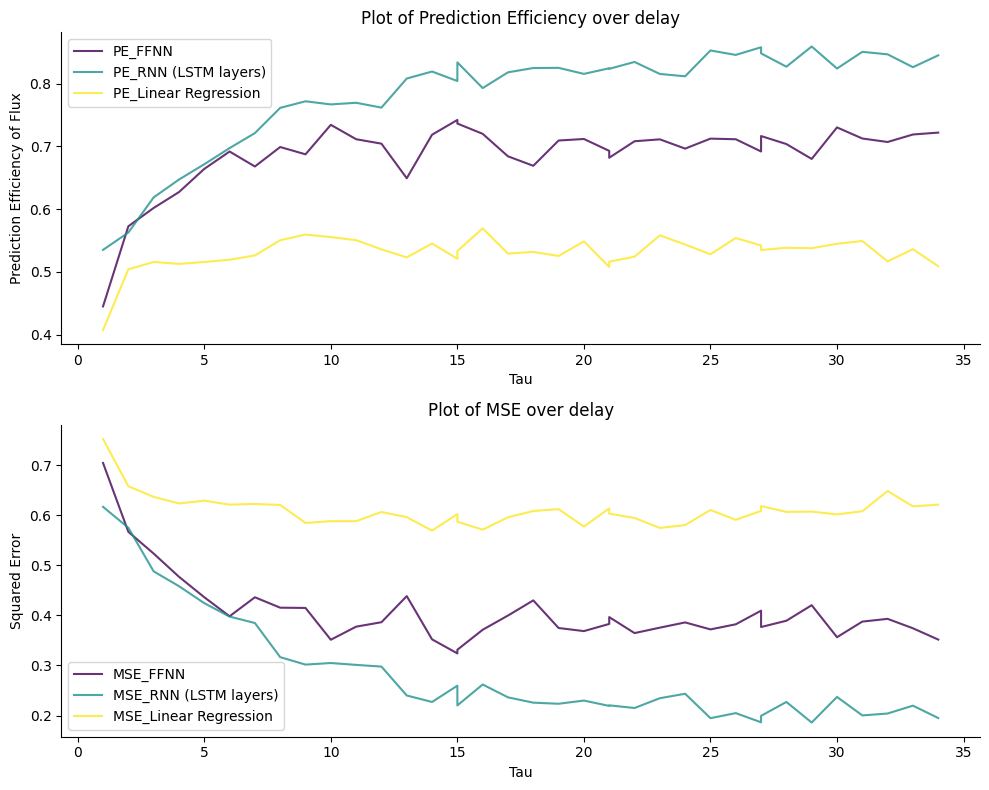

In [ ]:
main.plot_results_combo(m1, ['/content/drive/MyDrive/4th year/diss/delay_study_comb/ff_full', '/content/drive/MyDrive/4th year/diss/delay_study_comb/RNN_full', '/content/drive/MyDrive/4th year/diss/delay_study_comb/LR_full'],delay_study=True,rescaled=False, multi_en_channel=False)

In [ ]:
m1.plot_combo_ACE('/content/drive/MyDrive/4th year/diss/Final ACE dfs/test_ace_results_wave.csv')

In [ ]:
m1.plot_combo_ACE('/content/drive/MyDrive/4th year/diss/Final ACE dfs/test_ace_results_2.csv')

In [ ]:
folder_path = '/content/drive/MyDrive/4th year/diss/ACE_wave'

# List all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Read all CSV files into DataFrames and concatenate them
dfs = [pd.read_csv(os.path.join(folder_path, file), index_col=0) for file in csv_files]
concatenated_df = pd.concat(dfs)

# Sort by your index column, replace 'index_column' with your actual column name
sorted_df = concatenated_df.sort_values(by='Tau')

final_file_path = '/content/drive/MyDrive/4th year/diss/Final ACE dfs/' + 'test_ace_results_wave' + '.csv'
sorted_df.to_csv(final_file_path, index=True)


In [ ]:
arch = m1.make_architecture(num_of_layers=3)

In [ ]:
main.graph_multiple_prmtrs(m1)

In [ ]:
main.NARMAX(m1, days_ahead=1, back_log=15, polynomial_deg=2)

In [ ]:
m1.RNN_compile(days_ahead = 1, back_log = 15, AR = False)
m1.NN_train()
m1.NN_predict()

In [ ]:
main.graph_with_error(m1, 2000, 2001)
main.validate(m1)

In [ ]:
m1.save('LANL_FFNN')

L-Shell = 6.6 Re, Energy Channel = 1.8 MeV
/content/drive/MyDrive/4th year/diss/Results2/LANL_FFNN_1.8_MeV_at_L_6.6.csv


what is the method of this file?/content/drive/MyDrive/4th year/diss/Results2/GOES_FFNN_2_MeV_at_L_6.6.csv GOES
what is the method of this file?/content/drive/MyDrive/4th year/diss/Results2/LANL_FFNN_1.8_MeV_at_L_6.6.csv LANL


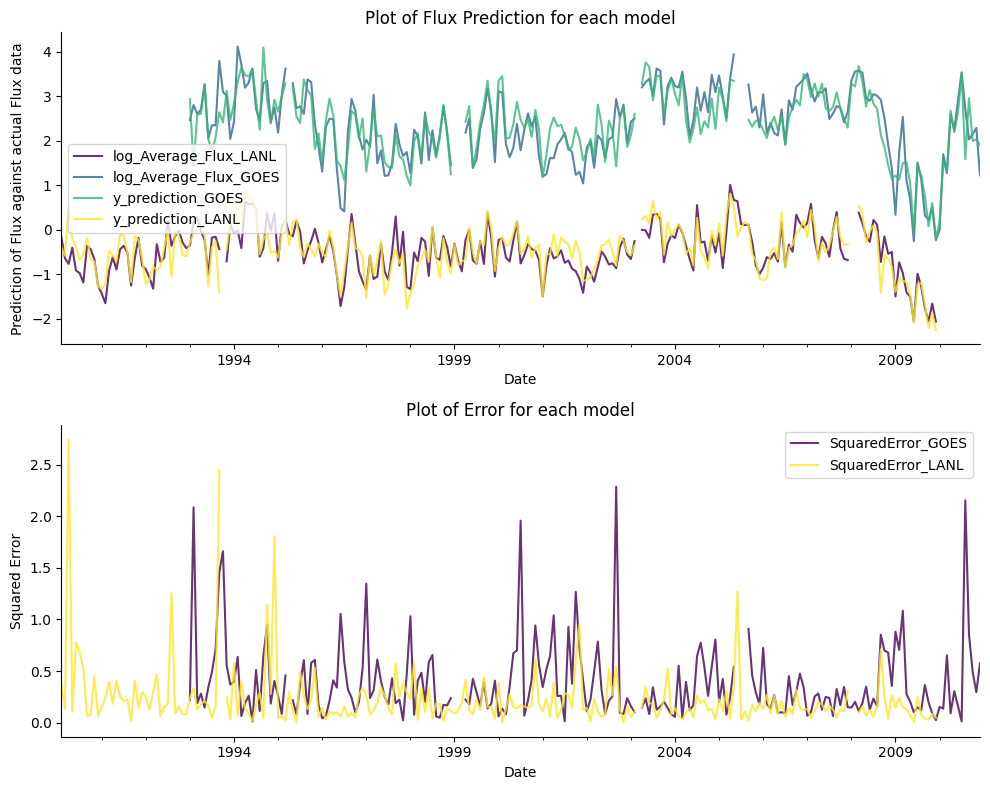

In [ ]:
main.plot_results_combo(m1, ['/content/drive/MyDrive/4th year/diss/Results2/GOES_FFNN_2_MeV_at_L_6.6.csv', '/content/drive/MyDrive/4th year/diss/Results2/LANL_FFNN_1.8_MeV_at_L_6.6.csv'], rescaled=False, multi_en_channel=True)

In [ ]:
def concatenate_and_sort_csvs(file_names, ascending=True):
    """
    Concatenate multiple CSV files and sort the resulting DataFrame.

    :param file_names: List of paths to CSV files
    :param sort_columns: Column or list of columns to sort by
    :param ascending: Sorting order (True for ascending, False for descending)
    :return: Concatenated and sorted DataFrame
    """
    # List to hold dataframes
    dfs = []

    # Loop through each file name
    for file_name in file_names:
        # Read the CSV file and append to list
        df = pd.read_csv(file_name)
        dfs.append(df)

    # Concatenate all dataframes in the list
    combined_df = pd.concat(dfs, ignore_index=True)

    # Sort the DataFrame
    #combined_df = combined_df.sort_values(by=sort_columns, ascending=ascending)

    return combined_df


ff_file_names = ['/content/drive/MyDrive/4th year/diss/delay_study/FFNN_from_19.csv', '/content/drive/MyDrive/4th year/diss/delay_study/FFNN_from_915.csv', '/content/drive/MyDrive/4th year/diss/delay_study/FFNN_from_1521.csv', '/content/drive/MyDrive/4th year/diss/delay_study/FFNN_from_2127.csv','/content/drive/MyDrive/4th year/diss/delay_study/FFNN_from_2734.csv' ]
LR_file_names = ['/content/drive/MyDrive/4th year/diss/delay_study/LR_from_19.csv','/content/drive/MyDrive/4th year/diss/delay_study/LR_from_915.csv', '/content/drive/MyDrive/4th year/diss/delay_study/LR_from_1521.csv', '/content/drive/MyDrive/4th year/diss/delay_study/LR_from_2127.csv', '/content/drive/MyDrive/4th year/diss/delay_study/LR_from_2734.csv']
NMX_file_names = ['/content/drive/MyDrive/4th year/diss/delay_study/NARMAX_from_19.csv', '/content/drive/MyDrive/4th year/diss/delay_study/NARMAX_from_915.csv', '/content/drive/MyDrive/4th year/diss/delay_study/NARMAX_from_1521.csv', '/content/drive/MyDrive/4th year/diss/delay_study/NARMAX_from_2127.csv', '/content/drive/MyDrive/4th year/diss/delay_study/NARMAX_from_2734.csv']
RNN_file_names = ['/content/drive/MyDrive/4th year/diss/delay_study/RNN_from_19.csv', '/content/drive/MyDrive/4th year/diss/delay_study/RNN_from_915.csv', '/content/drive/MyDrive/4th year/diss/delay_study/RNN_from_1521.csv', '/content/drive/MyDrive/4th year/diss/delay_study/RNN_from_2127.csv', '/content/drive/MyDrive/4th year/diss/delay_study/RNN_from_2734.csv']

ff_full = concatenate_and_sort_csvs(ff_file_names)
NMX_full = concatenate_and_sort_csvs(NMX_file_names)
LR_full = concatenate_and_sort_csvs(LR_file_names)
RNN_full = concatenate_and_sort_csvs(RNN_file_names)

In [ ]:
ff_full

In [ ]:
ff_full.to_csv('/content/drive/MyDrive/4th year/diss/delay_study_comb/ff_AR_full', index=True)
NMX_full.to_csv('/content/drive/MyDrive/4th year/diss/delay_study_comb/NMX_AR_full', index=True)
LR_full.to_csv('/content/drive/MyDrive/4th year/diss/delay_study_comb/LR_AR_full', index=True)
RNN_full.to_csv('/content/drive/MyDrive/4th year/diss/delay_study_comb/RNN_AR_full', index=True)

In [ ]:
df_edit = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/SOLAR_WIND/OMNI_raw/OMNI_FULL_1986_2019', index_col=0)

In [ ]:
df_edit

MAG_AVG_B-VECTOR_nT  BY__GSM_nT  BZ__GSM_nT  \
Date                                                                     
1986-01-01 06:30:00+00:00                 5.91        3.86       -1.32   
1986-01-01 06:35:00+00:00                 5.53        4.40       -0.58   
1986-01-01 06:40:00+00:00                 5.66        4.27       -1.07   
1986-01-01 06:45:00+00:00                 5.51        3.36       -2.66   
1986-01-01 06:50:00+00:00                 5.26        3.61       -1.72   
...                                        ...         ...         ...   
2019-02-28 23:40:00+00:00                 4.43       -3.29       -1.05   
2019-02-28 23:45:00+00:00                 4.25       -2.22       -0.10   
2019-02-28 23:50:00+00:00                 5.61       -2.36       -4.07   
2019-02-28 23:55:00+00:00                 5.95       -1.55       -4.54   
2019-03-01 00:00:00+00:00                 4.70        0.02       -3.78   

                           RMS_SD_B_SCALAR_nT  FLOW_SPEED__GSE_km/s  \
Date                                                                  
1986-01-01 06:30:00+00:00                0.00                 693.2   
1986-01-01 06:35:00+00:00                0.21                 710.3   
1986-01-01 06:40:00+00:00                0.06                 700.3   
1986-01-01 06:45:00+00:00                0.07                 697.1   
1986-01-01 06:50:00+00:00                0.03                 700.3   
...                                       ...                   ...   
2019-02-28 23:40:00+00:00                0.46                 569.1   
2019-02-28 23:45:00+00:00                0.05                 577.4   
2019-02-28 23:50:00+00:00                0.45                 575.1   
2019-02-28 23:55:00+00:00                0.14                 569.1   
2019-03-01 00:00:00+00:00                0.35                 576.5   

                           VX_VELOCITY__GSE_km/s  VY_VELOCITY__GSE_km/s  \
Date                                                                      
1986-01-01 06:30:00+00:00                 -684.2                  -26.3   
1986-01-01 06:35:00+00:00                 -700.8                  -23.0   
1986-01-01 06:40:00+00:00                 -695.1                  -31.0   
1986-01-01 06:45:00+00:00                 -691.8                  -28.4   
1986-01-01 06:50:00+00:00                 -699.1                  -13.6   
...                                          ...                    ...   
2019-02-28 23:40:00+00:00                 -568.8                   -4.2   
2019-02-28 23:45:00+00:00                 -576.8                   10.6   
2019-02-28 23:50:00+00:00                 -573.4                   14.4   
2019-02-28 23:55:00+00:00                 -566.8                   15.4   
2019-03-01 00:00:00+00:00                 -574.6                   -2.6   

                           VZ_VELOCITY__GSE_km/s  PROTON_DENSITY_n/cc  \
Date                                                                    
1986-01-01 06:30:00+00:00                 -108.4                 3.76   
1986-01-01 06:35:00+00:00                 -108.0                 3.62   
1986-01-01 06:40:00+00:00                  -35.5                 3.41   
1986-01-01 06:45:00+00:00                  -71.2                 4.00   
1986-01-01 06:50:00+00:00                    2.2                 3.19   
...                                          ...                  ...   
2019-02-28 23:40:00+00:00                  -15.8                 4.11   
2019-02-28 23:45:00+00:00                  -18.6                 4.29   
2019-02-28 23:50:00+00:00                  -40.8                 4.02   
2019-02-28 23:55:00+00:00                  -48.3                 4.03   
2019-03-01 00:00:00+00:00                  -46.3                 4.44   

                           TEMPERATURE_K  ...  Z_(S/C)__GSE_Re  \
Date                                      ...                    
1986-01-01 06:30:00+00:00       168000.0  ...             3.63   
1986-01-01 06:35

In [ ]:
m1.remove_mean()
m1.scale_for_ACE()

In [ ]:
m1.ACE_implement(prev_end=0, max_delays = 40)

* Starting outer iteration 000. Current err =  1.00000E+00
  Starting inner iteration 000. Current err =  1.00000E+00
  Starting inner iteration 001. Current err =  8.15152E-01
  Starting inner iteration 002. Current err =  7.91206E-01
  Starting inner iteration 003. Current err =  7.88138E-01
  Starting inner iteration 004. Current err =  7.87319E-01
  Starting inner iteration 005. Current err =  7.87019E-01
  Starting inner iteration 006. Current err =  7.86869E-01
  Starting inner iteration 007. Current err =  7.86763E-01
  Starting inner iteration 008. Current err =  7.86733E-01
* Starting outer iteration 001. Current err =  7.68422E-01
  Starting inner iteration 000. Current err =  7.68422E-01
  Starting inner iteration 001. Current err =  7.68395E-01
  Starting inner iteration 002. Current err =  7.67593E-01
  Starting inner iteration 003. Current err =  7.67273E-01
  Starting inner iteration 004. Current err =  7.67200E-01
  Starting inner iteration 005. Current err =  7.67155E-

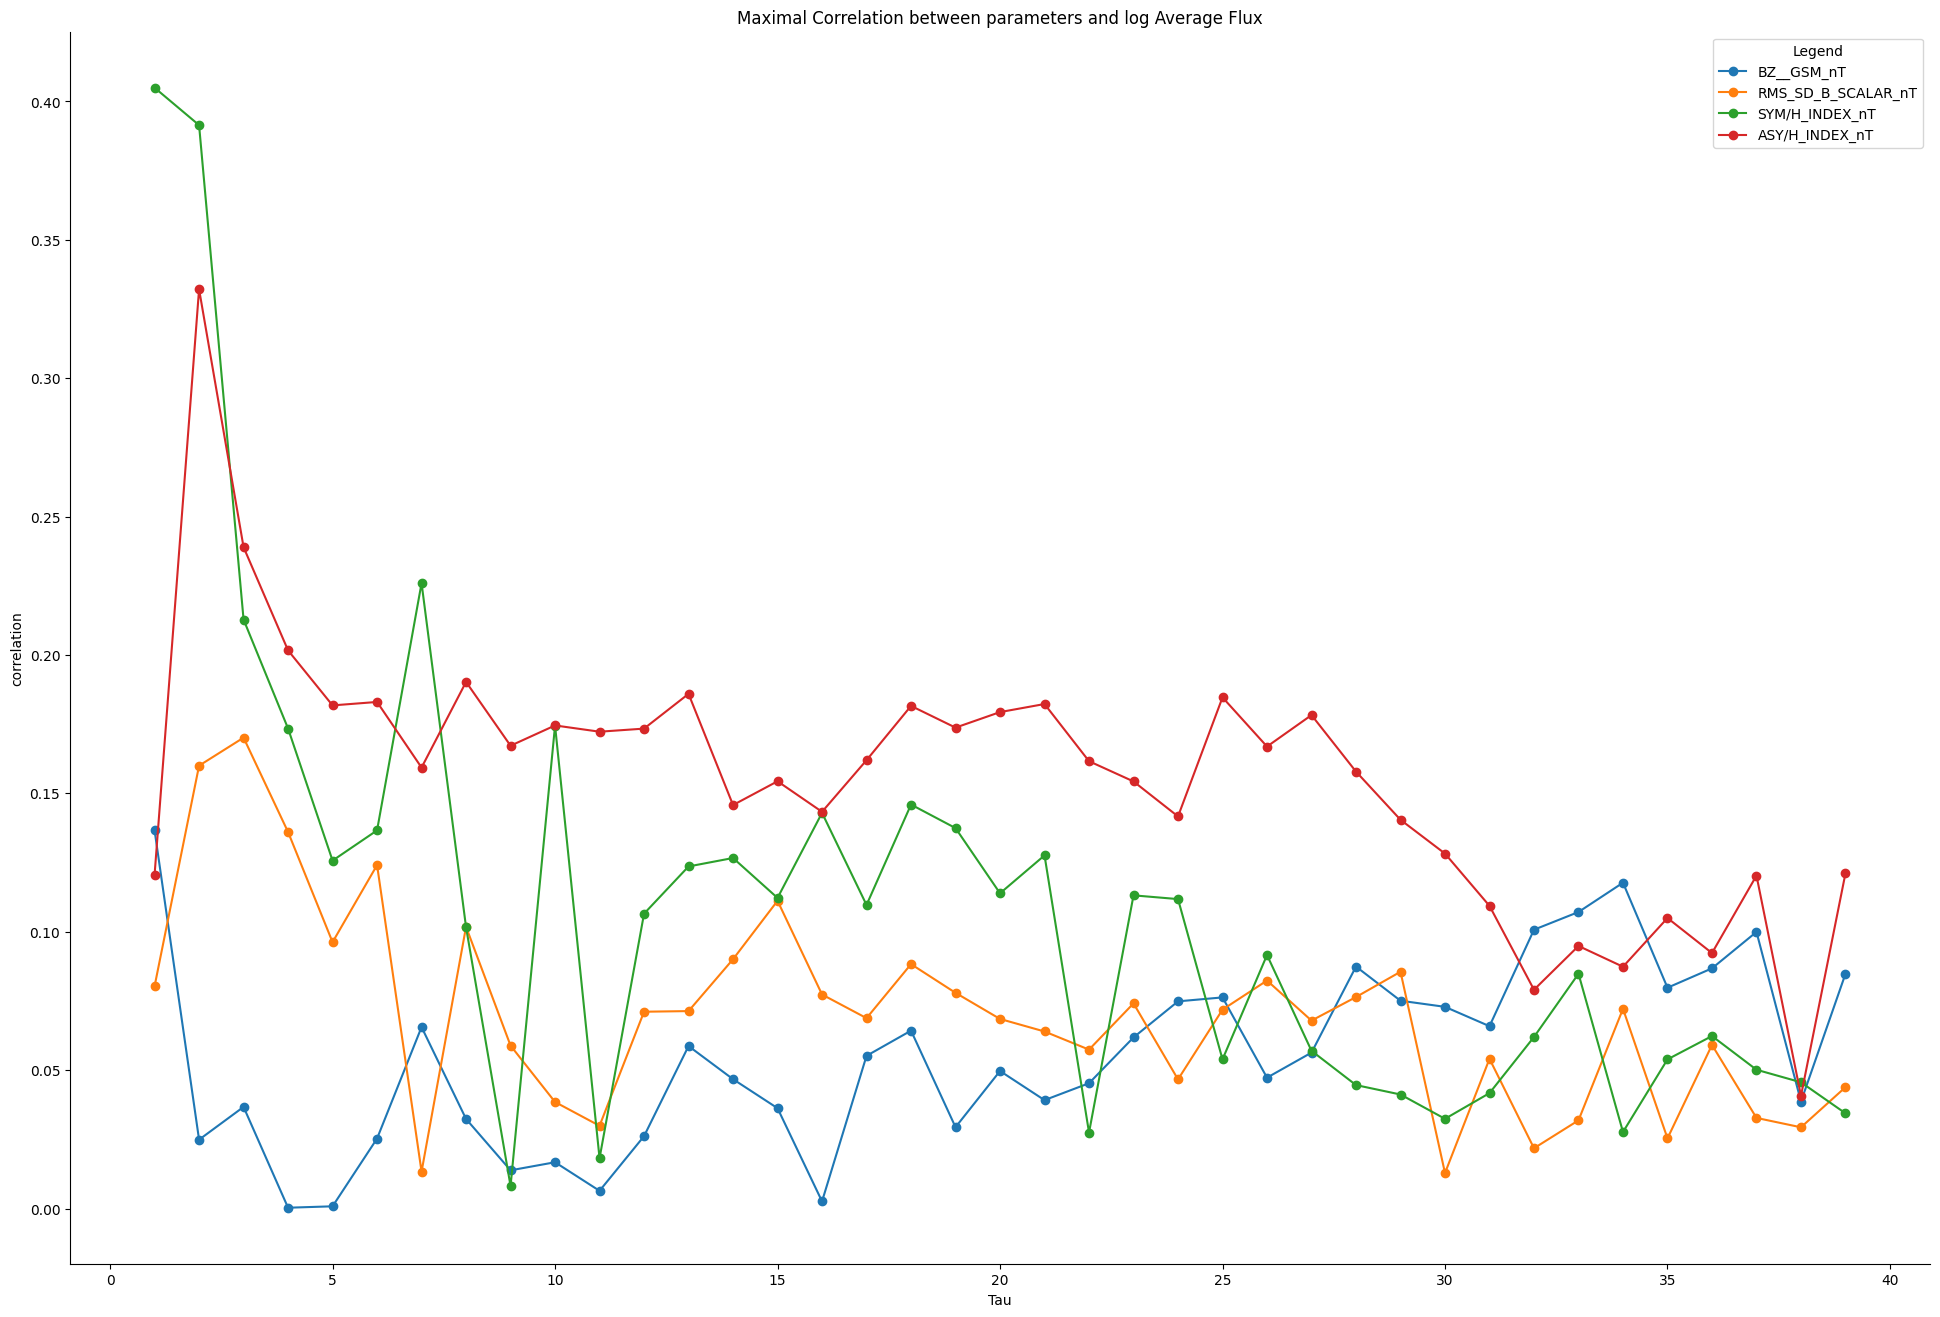

In [ ]:
m1.maxim_corr_plot(size=(24,16))

In [ ]:
main.save_ACE(m1)

/content/drive/MyDrive/4th year/diss/ACE_portions/add1_to_39.csv


In [ ]:
t, m3 = PINN_compile(batch_size_set = 400, exis_model=)#file_path = '/content/drive/MyDrive/4th year/test_csv.csv')

Epoch 1/10


Training: 100%|███████████████████| 6330/6330 [24:22<00:00,  4.33it/s]


- loss: 10.3493 - data_loss: 0.0028 - physics_loss: 12.9330

Epoch 2/10


Training: 100%|███████████████████| 6330/6330 [24:21<00:00,  4.33it/s]


- loss: 10.0279 - data_loss: 0.0028 - physics_loss: 12.5314

Epoch 3/10


Training: 100%|███████████████████| 6330/6330 [24:21<00:00,  4.33it/s]


- loss: 9.8452 - data_loss: 0.0028 - physics_loss: 12.3030

Epoch 4/10


Training: 100%|███████████████████| 6330/6330 [24:22<00:00,  4.33it/s]


- loss: 10.3527 - data_loss: 0.0028 - physics_loss: 12.9374

Epoch 5/10


Training: 100%|███████████████████| 6330/6330 [26:22<00:00,  4.00it/s]


- loss: 11.6692 - data_loss: 0.0028 - physics_loss: 14.5829

Epoch 6/10


Training: 100%|███████████████████| 6330/6330 [26:10<00:00,  4.03it/s]


- loss: 9.5143 - data_loss: 0.0028 - physics_loss: 11.8894

Epoch 7/10


Training: 100%|███████████████████| 6330/6330 [21:52<00:00,  4.82it/s]


- loss: 9.4217 - data_loss: 0.0028 - physics_loss: 11.7736

Epoch 8/10


Training: 100%|███████████████████| 6330/6330 [21:37<00:00,  4.88it/s]


- loss: 9.5989 - data_loss: 0.0028 - physics_loss: 11.9952

Epoch 9/10


Training: 100%|███████████████████| 6330/6330 [21:39<00:00,  4.87it/s]


- loss: 9.5761 - data_loss: 0.0028 - physics_loss: 11.9666

Epoch 10/10


Training: 100%|███████████████████| 6330/6330 [21:22<00:00,  4.93it/s]


- loss: 9.0961 - data_loss: 0.0028 - physics_loss: 11.3666



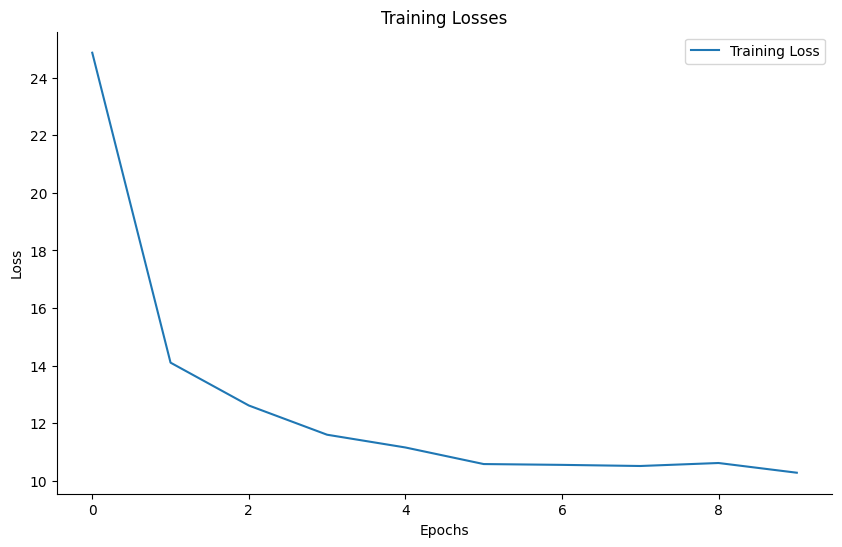

In [ ]:
plot_training(t)

In [ ]:
m2.save('/content/drive/MyDrive/4th year/diss/PINN_models/model1')

In [ ]:
df_val = y_sp[['time','BX__GSE_nT', 'BY__GSE_nT', 'VX_VELOCITY__GSE_km/s', 'VY_VELOCITY__GSE_km/s', 'PROTON_DENSITY_n/cc', 'FLOW_PRESSURE_nPa','X_(S/C)__GSE_Re', 'Y_(S/C)__GSE_Re','Z_(S/C)__GSE_Re', 'BZ__GSE_nT', 'VZ_VELOCITY__GSE_km/s']]
#df_test = y_sp[['X_(S/C)__GSE_Re', 'Y_(S/C)__GSE_Re', 'time', 'Z_(S/C)__GSE_Re']]

In [ ]:
df_test.to_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/SOLAR_WIND/PINN_solar_data/test_PINN_data_OMNI_cutdown.csv')

In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/SOLAR_WIND/PINN_solar_data/val_PINN_data_OMNI_cutdown.csv')
df_val

Unnamed: 0        time  BX__GSE_nT  BY__GSE_nT  \
0                 0         0.0       -4.21        3.89   
1                 1         5.0       -2.52        4.42   
2                 2        10.0       -2.81        4.30   
3                 3        15.0       -2.33        3.45   
4                 4        20.0       -2.21        3.67   
...             ...         ...         ...         ...   
2531889     2531889  17440870.0        2.44       -3.36   
2531890     2531890  17440875.0        3.04       -1.95   
2531891     2531891  17440880.0        2.83       -4.15   
2531892     2531892  17440885.0        2.24       -3.69   
2531893     2531893  17440890.0        0.07       -1.96   

         VX_VELOCITY__GSE_km/s  VY_VELOCITY__GSE_km/s  PROTON_DENSITY_n/cc  \
0                       -684.2                  -26.3                 3.76   
1                       -700.8                  -23.0                 3.62   
2                       -695.1                  -31.0                 3.41   
3                       -691.8                  -28.4                 4.00   
4                       -699.1                  -13.6                 3.19   
...                        ...                    ...                  ...   
2531889                 -568.8                   -4.2                 4.11   
2531890                 -576.8                   10.6                 4.29   
2531891                 -573.4                   14.4                 4.02   
2531892                 -566.8                   15.4                 4.03   
2531893                 -574.6                   -2.6                 4.44   

         FLOW_PRESSURE_nPa  X_(S/C)__GSE_Re  Y_(S/C)__GSE_Re  Z_(S/C)__GSE_Re  \
0                     3.61            28.70           -16.16             3.63   
1                     3.66            28.72           -16.13             3.64   
2                     3.34            28.75           -16.07             3.68   
3                     3.89            28.77           -16.04             3.70   
4                     3.12            28.81           -15.96             3.74   
...                    ...              ...              ...              ...   
2531889               2.67           259.02           -20.75             8.09   
2531890               2.86           259.02           -20.75             8.09   
2531891               2.66           259.02           -20.77             8.09   
2531892               2.61           259.03           -20.78             8.09   
2531893               2.95           259.03           -20.80             8.09   

         BZ__GSE_nT  VZ_VELOCITY__GSE_km/s  
0             -1.23                 -108.4  
1             -0.47                 -108.0  
2             -0.95                  -35.5  
3             -2.55                  -71.2  
4             -1.59                    2.2  
...             ...                    ...  
2531889        0.83                  -15.8  
2531890        1.08                  -18.6  
2531891       -2.23                  -40.8  
2531892       -3.06                  -48.3  
2531893       -3.23                  -46.3  

[2531894 rows x 13 columns]

In [ ]:
import pandas as pd
#pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/CRRES/CRRES_Hourly.csv', index_col = 0)

In [ ]:
df1.rename(columns={'EPOCH__yyyy-mm-ddThh:mm:ss.sssZ': 'Date'}, inplace=True)
#df2.rename(columns={'UT__yyyy-mm-ddThh:mm:ss.sssZ': 'Date'}, inplace=True)

In [ ]:
df = df1

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)
def make_timezone_aware(df, timezone='UTC'):
  if df.index.tz is None:
        # If timezone-naive, localize to the specified timezone
        df.index = df.index.tz_localize(timezone)
    # Return the possibly modified DataFrame
  return df
df = make_timezone_aware(df)

In [ ]:
df

X_(@_x_)_Re  Y_(@_y_)_Re  Z_(@_z_)_Re
Date                                                            
2011-01-01 00:30:00+00:00    -0.695184     6.508931    -0.784860
2011-01-01 01:30:00+00:00    -2.263254     6.028670    -1.420915
2011-01-01 02:30:00+00:00    -3.641627     5.142251    -1.944682
2011-01-01 03:30:00+00:00    -4.772329     3.905736    -2.335335
2011-01-01 04:30:00+00:00    -5.578398     2.403312    -2.566123
...                                ...          ...          ...
2017-11-30 19:30:00+00:00     5.744254    -2.616927     1.892760
2017-11-30 20:30:00+00:00     6.098280    -0.981645     2.298121
2017-11-30 21:30:00+00:00     6.036648     0.720735     2.545909
2017-11-30 22:30:00+00:00     5.563711     2.374116     2.619182
2017-11-30 23:30:00+00:00     4.711845     3.865800     2.512975

[60624 rows x 3 columns]

In [ ]:
df.to_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/GOES MAG/GOES15_EPHEMERIS_full.csv',index=True)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/GOES MAG/MAG_full.csv', index_col=0)

In [ ]:
df2.min()

X_GSE_(@_0_)_[nT]   -9999.0
Y_GSE_(@_1_)_[nT]   -9999.0
Z_GSE_(@_2_)_[nT]   -9999.0
dtype: float64

In [ ]:
df_filtered = df2[~(df2 < -9998.9).any(axis=1)]

In [ ]:
df_filtered.to_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/GOES MAG/MAG_full.csv', index=True)


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/GOES MAG/GOES15_EPHEMERIS_full.csv', index_col=0)
df2 = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/GOES MAG/MAG_full.csv', index_col=0)

In [ ]:
df2

X_GSE_(@_0_)_[nT]  Y_GSE_(@_1_)_[nT]  \
Date                                                              
2011-01-01 00:30:00+00:00         -30.921283         -32.825889   
2011-01-01 01:30:00+00:00         -19.254408         -29.719810   
2011-01-01 02:30:00+00:00          -9.552243         -25.806082   
2011-01-01 03:30:00+00:00          -3.496640         -19.743679   
2011-01-01 04:30:00+00:00           1.724634         -10.951662   
...                                      ...                ...   
2017-11-30 19:30:00+00:00         -50.488621           4.267065   
2017-11-30 20:30:00+00:00         -55.573214           1.015552   
2017-11-30 21:30:00+00:00         -60.564167          -3.030327   
2017-11-30 22:30:00+00:00         -63.371128          -7.843229   
2017-11-30 23:30:00+00:00         -63.028160         -12.937667   

                           Z_GSE_(@_2_)_[nT]  
Date                                          
2011-01-01 00:30:00+00:00          77.065385  
2011-01-01 01:30:00+00:00          75.387251  
2011-01-01 02:30:00+00:00          77.049276  
2011-01-01 03:30:00+00:00          79.567632  
2011-01-01 04:30:00+00:00          79.762444  
...                                      ...  
2017-11-30 19:30:00+00:00          99.325558  
2017-11-30 20:30:00+00:00          97.734766  
2017-11-30 21:30:00+00:00         101.303110  
2017-11-30 22:30:00+00:00          98.205570  
2017-11-30 23:30:00+00:00          92.322757  

[60216 rows x 3 columns]

In [ ]:
df_joined = pd.merge(df1, df2, left_index=True, right_index=True, how='inner')

In [ ]:
df_joined.dropna(inplace=True)

In [ ]:
df_joined.to_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/GOES MAG/combined_ephem_mag.csv', index=True)

In [ ]:
omni_data=pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/SOLAR_WIND/OMNI_raw/OMNI_FULL_1986_2019.csv', index_col=0)

In [ ]:
omni_data

MAG_AVG_B-VECTOR_nT  BY__GSM_nT  BZ__GSM_nT  \
Date                                                                     
1986-01-01 06:30:00+00:00                 5.91        3.86       -1.32   
1986-01-01 06:35:00+00:00                 5.53        4.40       -0.58   
1986-01-01 06:40:00+00:00                 5.66        4.27       -1.07   
1986-01-01 06:45:00+00:00                 5.51        3.36       -2.66   
1986-01-01 06:50:00+00:00                 5.26        3.61       -1.72   
...                                        ...         ...         ...   
2019-02-28 23:40:00+00:00                 4.43       -3.29       -1.05   
2019-02-28 23:45:00+00:00                 4.25       -2.22       -0.10   
2019-02-28 23:50:00+00:00                 5.61       -2.36       -4.07   
2019-02-28 23:55:00+00:00                 5.95       -1.55       -4.54   
2019-03-01 00:00:00+00:00                 4.70        0.02       -3.78   

                           RMS_SD_B_SCALAR_nT  FLOW_SPEED__GSE_km/s  \
Date                                                                  
1986-01-01 06:30:00+00:00                0.00                 693.2   
1986-01-01 06:35:00+00:00                0.21                 710.3   
1986-01-01 06:40:00+00:00                0.06                 700.3   
1986-01-01 06:45:00+00:00                0.07                 697.1   
1986-01-01 06:50:00+00:00                0.03                 700.3   
...                                       ...                   ...   
2019-02-28 23:40:00+00:00                0.46                 569.1   
2019-02-28 23:45:00+00:00                0.05                 577.4   
2019-02-28 23:50:00+00:00                0.45                 575.1   
2019-02-28 23:55:00+00:00                0.14                 569.1   
2019-03-01 00:00:00+00:00                0.35                 576.5   

                           VX_VELOCITY__GSE_km/s  VY_VELOCITY__GSE_km/s  \
Date                                                                      
1986-01-01 06:30:00+00:00                 -684.2                  -26.3   
1986-01-01 06:35:00+00:00                 -700.8                  -23.0   
1986-01-01 06:40:00+00:00                 -695.1                  -31.0   
1986-01-01 06:45:00+00:00                 -691.8                  -28.4   
1986-01-01 06:50:00+00:00                 -699.1                  -13.6   
...                                          ...                    ...   
2019-02-28 23:40:00+00:00                 -568.8                   -4.2   
2019-02-28 23:45:00+00:00                 -576.8                   10.6   
2019-02-28 23:50:00+00:00                 -573.4                   14.4   
2019-02-28 23:55:00+00:00                 -566.8                   15.4   
2019-03-01 00:00:00+00:00                 -574.6                   -2.6   

                           VZ_VELOCITY__GSE_km/s  PROTON_DENSITY_n/cc  \
Date                                                                    
1986-01-01 06:30:00+00:00                 -108.4                 3.76   
1986-01-01 06:35:00+00:00                 -108.0                 3.62   
1986-01-01 06:40:00+00:00                  -35.5                 3.41   
1986-01-01 06:45:00+00:00                  -71.2                 4.00   
1986-01-01 06:50:00+00:00                    2.2                 3.19   
...                                          ...                  ...   
2019-02-28 23:40:00+00:00                  -15.8                 4.11   
2019-02-28 23:45:00+00:00                  -18.6                 4.29   
2019-02-28 23:50:00+00:00                  -40.8                 4.02   
2019-02-28 23:55:00+00:00                  -48.3                 4.03   
2019-03-01 00:00:00+00:00                  -46.3                 4.44   

                           TEMPERATURE_K  ...  Z_(S/C)__GSE_Re  \
Date                                      ...                    
1986-01-01 06:30:00+00:00       168000.0  ...             3.63   
1986-01-01 06:35

In [ ]:
reference_date = pd.to_datetime('1986-01-01 06:30:00+00:00')

In [ ]:
import pandas as pd
df = m1.df
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)
def make_timezone_aware(df, timezone='UTC'):
  if df.index.tz is None:
        # If timezone-naive, localize to the specified timezone
        df.index = df.index.tz_localize(timezone)
    # Return the possibly modified DataFrame
  return df
df_joined = make_timezone_aware(df)

KeyError: 'Date'

In [ ]:
timedelta_seconds = (m1.df.index - reference_date).total_seconds()

In [ ]:
m1.df['time'] = timedelta_seconds

In [ ]:
m1.df.set_index('time', inplace=True)

In [ ]:
m1.df.to_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/CRRES/CRRES_for_pinn.csv', index=True)

In [ ]:
df_joined

log_Average_Flux_si
time                            
219475949.0             4.759733
219562349.0             4.766029
219648749.0             4.768634
219994349.0             4.757203
220080749.0             4.766079
...                          ...
788419954.0             5.178586
788506354.0             5.239178
788592754.0             4.842706
788679154.0             3.684315
788765554.0             3.663540

[8217 rows x 1 columns]

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/MAG_EARTH_FULL_time_ind.csv')
df

time  BH_(GEOMAG_N-S)_(@_H_)_nT  BD_(GEOMAG_E-W)_(@_D_)_nT  \
0       4174172.5                      -43.5                      164.8   
1       4174177.5                      -44.4                      166.8   
2       4174182.5                      -47.6                      167.0   
3       4174187.5                      -48.8                      167.0   
4       4174192.5                      -48.4                      167.2   
...           ...                        ...                        ...   
826555  8306946.5                       52.8                      133.0   
826556  8306951.5                       48.0                      133.0   
826557  8306956.5                       45.4                      135.0   
826558  8306961.5                       49.2                      135.4   
826559  8306966.5                       51.2                      133.8   

        BZ_(VERTICAL)_(@_Z_)_nT  
0                         -56.4  
1                         -57.4  
2                         -57.6  
3                         -57.6  
4                         -57.4  
...                         ...  
826555                    -20.4  
826556                    -21.0  
826557                    -21.2  
826558                    -22.0  
826559                    -22.8  

[826560 rows x 4 columns]

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/MAG_EARTH_FULL_time_ind.csv')
df1 = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/MAG_EARTH_FULL_time_ind.csv')
def  HDZ_to_GEO(row):
  latitude = np.radians(-76)
  longitude = np.radians(-27)
  R = np.array([
    [-np.sin(longitude), -np.sin(latitude) * np.cos(longitude), np.cos(latitude) * np.cos(longitude)],
    [np.cos(longitude), -np.sin(latitude) * np.sin(longitude), np.cos(latitude) * np.sin(longitude)],
    [0, np.cos(latitude), np.sin(latitude)]
  ])
  #(76° S, 27° W)
  H = row['BH_(GEOMAG_N-S)_(@_H_)_nT']
  D = np.radians(row['BD_(GEOMAG_E-W)_(@_D_)_nT'])
  Z = row['BZ_(VERTICAL)_(@_Z_)_nT']

  HED = np.array([H * np.cos(D), H * np.sin(D), Z])
  XYZ = R.dot(HED)
  return pd.Series(XYZ, index=['X_nT', 'Y_nT', 'Z_nT'])
df[['X_nT', 'Y_nT', 'Z_nT']] = df.apply(HDZ_to_GEO, axis=1)

In [ ]:
import pandas as pd
import numpy as np
import spacepy.coordinates as spc
from spacepy.time import Ticktock

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/toedittoGSM.csv')
df1 = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/MAG_EARTH_FULL.csv')
df

Date       time  BH_(GEOMAG_N-S)_(@_H_)_nT  \
0       1993-12-09 00:02:30+00:00  4174172.5                      -43.5   
1       1993-12-09 00:07:30+00:00  4174177.5                      -44.4   
2       1993-12-09 00:12:30+00:00  4174182.5                      -47.6   
3       1993-12-09 00:17:30+00:00  4174187.5                      -48.8   
4       1993-12-09 00:22:30+00:00  4174192.5                      -48.4   
...                           ...        ...                        ...   
826555  2001-10-17 23:36:30+00:00  8306946.5                       52.8   
826556  2001-10-17 23:41:30+00:00  8306951.5                       48.0   
826557  2001-10-17 23:46:30+00:00  8306956.5                       45.4   
826558  2001-10-17 23:51:30+00:00  8306961.5                       49.2   
826559  2001-10-17 23:56:30+00:00  8306966.5                       51.2   

        BD_(GEOMAG_E-W)_(@_D_)_nT  BZ_(VERTICAL)_(@_Z_)_nT       X_nT  \
0                           164.8                    -56.4  -2.959808   
1                           166.8                    -57.4  -1.513573   
2                           167.0                    -57.6  -0.617031   
3                           167.0                    -57.6  -0.319580   
4                           167.2                    -57.4  -0.216120   
...                           ...                      ...        ...   
826555                      133.0                    -20.4  12.639338   
826556                      133.0                    -21.0  10.961220   
826557                      135.0                    -21.2   8.609976   
826558                      135.4                    -22.0   9.220094   
826559                      133.8                    -22.8  10.945288   

             Y_nT       Z_nT   GSE_X_nT   GSE_Y_nT   GSE_Z_nT  
0       48.621352  51.965504 -15.396225 -53.076692  44.933629  
1       49.285892  53.242182 -16.207916 -53.810189  45.911731  
2       52.367901  53.298614 -15.816539 -56.849501  45.842026  
3       53.528615  53.233309 -14.899791 -57.933566  46.053210  
4       53.080807  53.100859 -13.930178 -57.382458  46.373738  
...           ...        ...        ...        ...        ...  
826555 -46.854486  29.135962 -15.523648  34.138905  42.397542  
826556 -42.325404  28.868873 -14.914010  29.731611  40.479669  
826557 -40.416646  28.336603 -13.409536  27.855149  39.431904  
826558 -44.014848  29.703923 -15.201536  30.601002  41.678916  
826559 -45.349597  31.062754 -18.130289  31.217932  42.872058  

[826560 rows x 11 columns]

In [ ]:

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)
def make_timezone_aware(df, timezone='UTC'):
  if df.index.tz is None:
        # If timezone-naive, localize to the specified timezone
        df.index = df.index.tz_localize(timezone)
    # Return the possibly modified DataFrame
  return df
df_joined = make_timezone_aware(df)

In [ ]:
df_joined.min()

time                         4.174172e+06
BH_(GEOMAG_N-S)_(@_H_)_nT   -2.150000e+09
BD_(GEOMAG_E-W)_(@_D_)_nT   -2.150000e+09
BZ_(VERTICAL)_(@_Z_)_nT     -2.150000e+09
X_nT                        -2.713994e+03
Y_nT                        -1.029214e+09
Z_nT                        -1.783330e+03
GSE_X_nT                    -2.482299e+09
GSE_Y_nT                    -2.474029e+09
GSE_Z_nT                    -2.433005e+03
dtype: float64

In [ ]:
min_value = -2.150000e+08
df_filtered_columns = df_joined[df_joined['BH_(GEOMAG_N-S)_(@_H_)_nT'] >= min_value]

In [ ]:
df_filtered_columns.max()

time                         8.306966e+06
BH_(GEOMAG_N-S)_(@_H_)_nT    1.472000e+03
BD_(GEOMAG_E-W)_(@_D_)_nT    1.350400e+03
BZ_(VERTICAL)_(@_Z_)_nT      1.706200e+03
X_nT                         2.377487e+03
Y_nT                         3.241243e+03
Z_nT                         2.111871e+03
GSE_X_nT                     2.812728e+03
GSE_Y_nT                     2.297263e+03
GSE_Z_nT                     2.879291e+03
dtype: float64

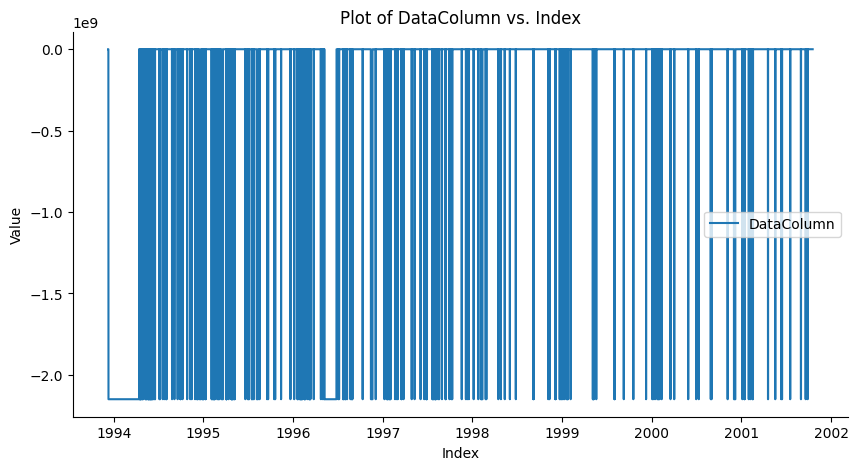

In [ ]:
column_to_plot = df_joined['BH_(GEOMAG_N-S)_(@_H_)_nT']

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(column_to_plot, label='DataColumn')
plt.title('Plot of DataColumn vs. Index')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
def convert_to_gsm(row):
    # Convert geographic (LAT, LONG, ALT) to GSM coordinates for a single row
    time = Ticktock([row.name.to_pydatetime()], 'UTC')  # Convert index (UTC time) to Ticktock
    geo_coords = spc.Coords([[row['X_nT'], row['Y_nT'], row['Z_nT']]], 'GEO', 'car', ticks=time, units=['Re', 'Re', 'Re'])
    #gse_coords = spc.Coords([[row['X_(S/C)__GSE_Re'],row['Y_(S/C)__GSE_Re'],row['Z_(S/C)__GSE_Re']]], 'GSE', 'car', ticks=time, units=['Re', 'Re', 'Re'])
    gsm_coords = geo_coords.convert('GSM', 'car')
    return pd.Series(gsm_coords.data[0])

df_n = df_joined.apply(convert_to_gsm, axis=1)
df_n.columns = ['GEO_X', 'GEO_Y', 'GEO_Z']
df_joined['GSM_X_nT'] = df_n['GEO_X']
df_joined['GSM_Y_nT'] = df_n['GEO_Y']
df_joined['GSM_Z_nT'] = df_n['GEO_Z']

In [ ]:
df_joined = df_filtered_columns
df_f = pd.DataFrame()
df_f['time'] = df_joined['time']
df_f['GSE_X_nT'] = df_joined['GSE_X_nT']
df_f['GSE_Y_nT'] = df_joined['GSE_Y_nT']
df_f['GSE_Z_nT'] = df_joined['GSE_Z_nT']

In [ ]:
df_joined.to_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/toedittoGSM.csv', index=True)

In [ ]:
df_f.to_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/GSE_ver.csv')

In [ ]:
pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/GSM_ver.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/4th year/diss/Data_for_FYP/EARTH_MAG/GSM_ver.csv'

In [ ]:
goes_df = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/Energetic particle sensor/GOES_comb/GOES_1992_2010')

In [ ]:
goes_df

Date  log_Average_Flux
0     1992-12-15 12:02:29+00:00          0.759733
1     1992-12-16 12:02:29+00:00          0.766029
2     1992-12-17 12:02:29+00:00          0.768634
3     1992-12-21 12:02:29+00:00          0.757203
4     1992-12-22 12:02:29+00:00          0.766079
...                         ...               ...
8212  2010-12-26 12:02:34+00:00          1.178586
8213  2010-12-27 12:02:34+00:00          1.239178
8214  2010-12-28 12:02:34+00:00          0.842706
8215  2010-12-29 12:02:34+00:00         -0.315685
8216  2010-12-30 12:02:34+00:00         -0.336460

[8217 rows x 2 columns]

In [ ]:
from math import floor, log10
goes_df = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/Energetic particle sensor/GOES_comb/GOES_1992_2010')
def convertlog_norm(flux):
  return 10 ** flux

def convert_cm2tom2(flux):
  return flux * 10000

def convert_log_10(x):
    """
    Safely compute the base-10 logarithm of x.
    Sets a lower bound to avoid logarithm of zero or negative numbers.
    """
    return np.log10(x)

goes_df[['Average_Flux']] = goes_df[['log_Average_Flux']].apply(convertlog_norm)
goes_df.drop(['log_Average_Flux'], axis=1, inplace=True)
goes_df[['Average_Flux_si']] = goes_df[['Average_Flux']].apply(convert_cm2tom2)
#goes_df.drop(['Average_Flux'])
goes_df[['log_Average_Flux_si']] = goes_df[['Average_Flux_si']].apply(convert_log_10)
#goes_df.drop(['Average_Flux_si'])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compare_data_availability(dataframes, labels=None):
    # Check if labels are provided, else use default labels
    if labels is None:
        labels = [f'Dataframe {i+1}' for i in range(len(dataframes))]

    # Number of dataframes
    num_dfs = len(dataframes)

    # Setting up the plot
    fig, axes = plt.subplots(nrows=num_dfs, figsize=(10, 3 * num_dfs))

    # If only one dataframe, axes is not a list
    if num_dfs == 1:
        axes = [axes]

    # Iterate over each dataframe and its corresponding axis
    for df, ax, label in zip(dataframes, axes, labels):
        # Create a 'Available' column
        df['Available'] = df.notna().astype(int)

        # Create pivot table for heatmap
        heatmap_data = df.pivot_table(index=df.index.year, columns=df.index.month, values='Available', aggfunc='sum')

        # Create heatmap
        sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, annot=False, cbar=True, ax=ax, vmin=0, vmax=50)
        ax.set_title(f'Data Availability for {label}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Year')

    plt.tight_layout()
    plt.show()

In [ ]:
df_crres = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/CRRES/CRRES_Hourly.csv')
df_crres['Date'] = pd.to_datetime(df_crres['Date'])
df_crres.set_index('Date', inplace=True)
df_GOES = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/Energetic particle sensor/GOES_comb/GOES_1992_2010')
df_GOES['Date'] = pd.to_datetime(df_GOES['Date'])
df_GOES.set_index('Date', inplace=True)
df_LANL = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/LANL/ESP.csv')
df_LANL['Date'] = pd.to_datetime(df_LANL['Date'])
df_LANL.set_index('Date', inplace=True)

df_crres_flux = pd.DataFrame()
df_GOES_flux = pd.DataFrame()
df_LANL_flux = pd.DataFrame()

df_crres_flux[['log_Average_Flux']] = df_crres[['AVERAGE_MEA_FLUX_(@_148.00_keV)_1/[cm**2-s-sr-keV]']]
df_GOES_flux[['log_Average_Flux']] = df_GOES[['log_Average_Flux']]
df_LANL_flux[['log_Average_Flux']] = df_LANL[['log(E234)']]
df_list = [df_GOES_flux, df_LANL_flux]
def make_timezone_aware(df, timezone='UTC'):
      if df.index.tz is None:
            # If timezone-naive, localize to the specified timezone
            df.index = df.index.tz_localize(timezone)
        # Return the possibly modified DataFrame
      return df

for i in df_list:
  i = make_timezone_aware(i)



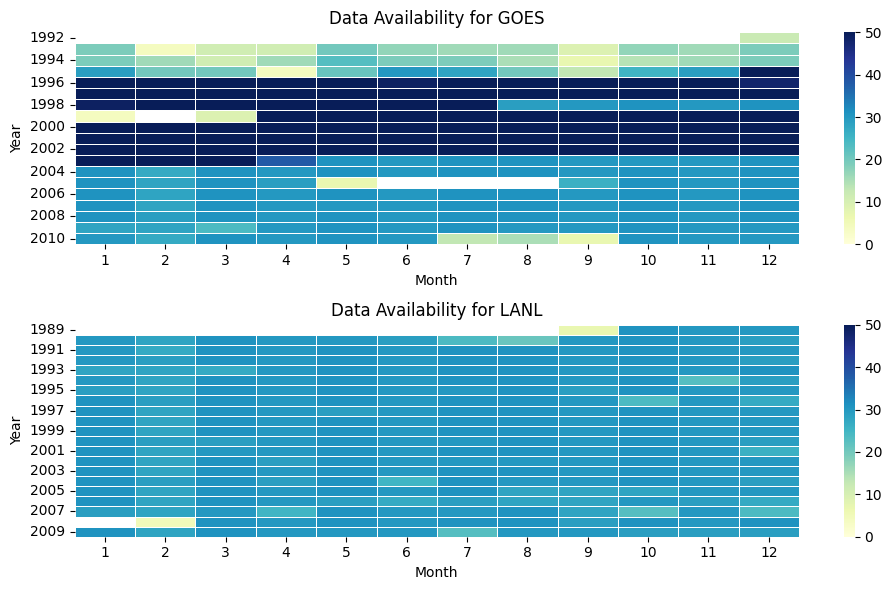

In [ ]:
compare_data_availability(df_list, labels=['GOES', 'LANL'])

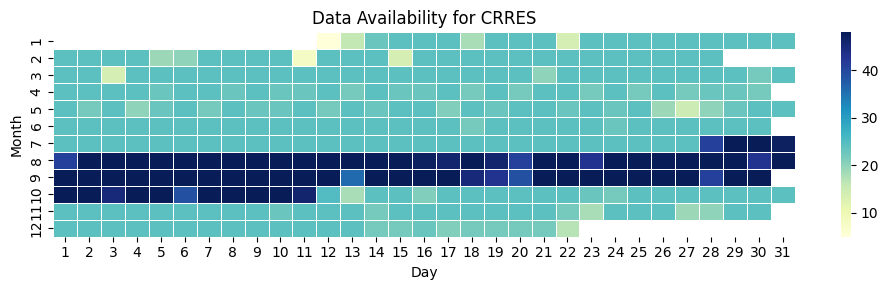

In [ ]:
compare_data_availability([df_crres_flux], labels=['CRRES'])

In [ ]:
df_crres

LONG__Deg_E  LAT__Deg_N     ALT__km     L__RE  \
Date                                                                       
1990-07-28 07:00:00+00:00    272.60018  -14.207452   5815.2807  1.974096   
1990-07-28 08:00:00+00:00    313.54128   -6.345583  18064.6730  4.013432   
1990-07-28 09:00:00+00:00    315.35207   -1.027626  26144.9670  5.415064   
1990-07-28 10:00:00+00:00    311.16075    2.514910  30991.3480  6.321911   
1990-07-28 11:00:00+00:00    305.05087    5.358931  33245.6180  6.844528   
...                                ...         ...         ...       ...   
1991-10-11 20:00:00+00:00    282.94643    7.535299  24866.8780  5.574966   
1991-10-11 21:00:00+00:00    288.26965   12.592768  15573.5720  4.216889   
1991-10-11 22:00:00+00:00    206.83085    8.111862   3405.0838  1.787085   
1991-10-11 23:00:00+00:00    141.43980  -16.188627   9965.7307  3.087279   
1991-10-12 00:00:00+00:00    159.48839  -12.012339  19619.8450  4.587649   

                                 B__nT  MLT__Hour  \
Date                                                
1990-07-28 07:00:00+00:00   8728.89520   7.447649   
1990-07-28 08:00:00+00:00    524.68450   5.091787   
1990-07-28 09:00:00+00:00    217.47683   6.199719   
1990-07-28 10:00:00+00:00    153.95553   6.902461   
1990-07-28 11:00:00+00:00    139.50422   7.477433   
...                                ...        ...   
1991-10-11 20:00:00+00:00    287.96435  15.486093   
1991-10-11 21:00:00+00:00   1005.49100  16.836888   
1991-10-11 22:00:00+00:00  14641.53500  14.064025   
1991-10-11 23:00:00+00:00   3871.52580   9.154305   
1991-10-12 00:00:00+00:00    549.53060  11.183800   

                           AVERAGE_MEA_FLUX_(@_148.00_keV)_1/[cm**2-s-sr-keV]  \
Date                                                                            
1990-07-28 07:00:00+00:00                                          8815.3953    
1990-07-28 08:00:00+00:00                                          5125.3832    
1990-07-28 09:00:00+00:00                                          5226.7207    
1990-07-28 10:00:00+00:00                                          1327.8765    
1990-07-28 11:00:00+00:00                                          3165.2418    
...                                                                      ...    
1991-10-11 20:00:00+00:00                                         12492.8220    
1991-10-11 21:00:00+00:00                                         12880.3450    
1991-10-11 22:00:00+00:00                                          6733.1587    
1991-10-11 23:00:00+00:00                                         16719.5410    
1991-10-12 00:00:00+00:00                                         16324.6610    

                           AVERAGE_MEA_FLUX_(@_214.00_keV)_1/[cm**2-s-sr-keV]  \
Date                                                                            
1990-07-28 07:00:00+00:00                                         7190.33940    
1990-07-28 08:00:00+00:00                                         1408.23140    
1990-07-28 09:00:00+00:00                                          813.07326    
1990-07-28 10:00:00+00:00                                          125.92437    
1990-07-28 11:00:00+00:00                                          150.39423    
...                                                                      ...    
1991-10-11 20:00:00+00:00                                         7649.72080    
1991-10-11 21:00:00+00:00                                        10915.30100    
1991-10-11 22:00:00+00:00                                         5950.87070    
1991-10-11 23:00:00+00:00                                        13118.87400    
1991-10-12 00:00:00+00:00                                        13330.23800    

                           AVERAGE_MEA_FLUX_(@_272.00_keV)_1/[cm**2-s-sr-keV]  \
Date                                                                            
1990-07-28 07:00:00+00:00                                        5555.039200  

In [ ]:

variance_max = df_crres['B__nT'].max() * 1000#.var()
variance_row = df_crres['B__nT'].values * 1000
variance_scl = variance_row
variance = variance_scl.var()

In [ ]:
print(variance)

15139622135512.068


In [ ]:
df_str = pd.read_csv('/content/drive/MyDrive/4th year/diss/Data_for_FYP/GOES MAG/combined_ephem_mag.csv')

In [ ]:
df_str

time  X_(@_x_)_Re  Y_(@_y_)_Re  Z_(@_z_)_Re  X_GSE_(@_0_)_[nT]  \
0      13148280.0    -0.695184     6.508931    -0.784860         -30.921283   
1      13148340.0    -2.263254     6.028670    -1.420915         -19.254408   
2      13148400.0    -3.641627     5.142251    -1.944682          -9.552243   
3      13148460.0    -4.772329     3.905736    -2.335335          -3.496640   
4      13148520.0    -5.578398     2.403312    -2.566123           1.724634   
...           ...          ...          ...          ...                ...   
60211  16785420.0     5.744254    -2.616927     1.892760         -50.488621   
60212  16785480.0     6.098280    -0.981645     2.298121         -55.573214   
60213  16785540.0     6.036648     0.720735     2.545909         -60.564167   
60214  16785600.0     5.563711     2.374116     2.619182         -63.371128   
60215  16785660.0     4.711845     3.865800     2.512975         -63.028160   

       Y_GSE_(@_1_)_[nT]  Z_GSE_(@_2_)_[nT]  
0             -32.825889          77.065385  
1             -29.719810          75.387251  
2             -25.806082          77.049276  
3             -19.743679          79.567632  
4             -10.951662          79.762444  
...                  ...                ...  
60211           4.267065          99.325558  
60212           1.015552          97.734766  
60213          -3.030327         101.303110  
60214          -7.843229          98.205570  
60215         -12.937667          92.322757  

[60216 rows x 7 columns]

In [ ]:
variance = df_str['X_GSE_(@_0_)_[nT]'].var()
print(variance)

1344.4796540363313


In [ ]:
!pip install -r https://raw.githubusercontent.com/samuelkim314/DeepSymReg/master/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.15 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.15


In [ ]:
!git clone https://github.com/samuelkim314/DeepSymReg.git

Cloning into 'DeepSymReg'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 47 (delta 10), reused 1 (delta 0), pack-reused 22
Receiving objects: 100% (47/47), 49.76 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
%cd DeepSymReg
import sys
sys.path.append('.')
!pip install .

/content/DeepSymReg/DeepSymReg
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
import numpy as np
!pip install tensorflow==1.15.0
import tensorflow as tf

import tensorflow as tf
from utils import functions, pretty_print
from utils.symbolic_network import SymbolicNetL0
from utils.regularization import l12_smooth

ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==1.15.0


In [ ]:
# Disable eager execution for this code block
tf.compat.v1.disable_eager_execution()
funcs = functions.default_func
x_dim = 1
# Random data for a simple function
x = np.random.rand(100, x_dim) * 2 - 1
y = x ** 2

# Set up TensorFlow graph for the EQL network
x_placeholder = tf.compat.v1.placeholder(shape=(None, x_dim), dtype=tf.float32)
sym = SymbolicNetL0(symbolic_depth=2, funcs=funcs, init_stddev=0.5)
y_hat = sym(x_placeholder)

# Set up loss function with L0.5 loss
mse = tf.losses.mean_squared_error(labels=y, predictions=y_hat)
loss = mse + 1e-2 * sym.get_loss()

# Set up TensorFlow graph for training
opt = tf.train.RMSPropOptimizer(learning_rate=1e-2)
train = opt.minimize(loss)

# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        sess.run(train, feed_dict={x_placeholder: x})

    # Print out the expression
    weights = sess.run(sym.get_weights())
    expr = pretty_print.network(weights, funcs, ['x'])
    print(expr)

AttributeError: module 'tensorflow' has no attribute 'random_uniform'

In [ ]:
def loss_fcn(y_true, y_pred, x_true):
  # 1 - y_pred = tensor with all the selected nodes of value 0 or 1 (have to find a way to make that so)
  # 2 - based on the selected output nodes for each input parameter a calculation is performed (e.g. for each output node this corresponds to a function of the input parameters)
  # 3 - y_pred_value is the result of the functions on x_true parameters
  # final output will be a prediction plot based upon the network but secondary output will be an expression that can then be used as an outputter

  # output of shape [batch_size, ]

  # expression op11(param1)*op12(param2)*op13(param3)...op1n(paramn)    connectop1     op21(param1)*op22(param2)*op23(param3)...op2n(paramn)     connectop2      op31(param1)*op32(param2)*op33(param3)...op3n(paramn)      .....  connectopn     opn1(param1)*opn2(param2)*opn3(param3)...opnn(paramn)


  # expression would have n+1 terms and n params with n * (n+1) operations: so overall output dims would be for 6 with delay up to 10 inputs: 3780


  # connect ops would have 4 choices

  # main ops would have; sqrd, cbd, tms, dvd, sin(), cos()

  # 1) divide y_pred into conops and main ops as 1 list and n lists

  # for i in conops:
    #

  # for i in main ops:
    # for i2 in i:
        #